#  Working with RDD

# Data Loading 

## Spark Context from Spark Session

In [1]:
# Import SparkConf class into program
from pyspark import SparkConf
from pyspark import SparkContext # Spark
from pyspark.sql import SparkSession # Spark SQL
from datetime import datetime
from pyspark.rdd import RDD
import csv
from pyspark.sql import Row
from pyspark.sql.types import *
from pyspark.sql.functions import to_timestamp
from pyspark.sql.functions import udf
from pyspark.sql.functions import dayofweek
from pyspark.sql.functions import weekofyear
from pyspark.sql.functions import when
from pyspark.sql.window import Window
import pyspark.sql.functions as func
import numpy as np
import matplotlib.pyplot as plt

# Run as many thread as there are on my machine
master = "local[*]"
# The `appName` field is a name to be shown on the Spark cluster UI page
app_name = "FIT5202 Assignment 1"
# Setup configuration parameters for Spark
spark_conf = SparkConf().setMaster(master).setAppName(app_name).set('spark.sql.session.timeZone', 'Australia/Melbourne')

# Getting spark context from spark session
spark = SparkSession.builder.config(conf=spark_conf).getOrCreate()
sc = spark.sparkContext
sc.setLogLevel('ERROR')

## Reading the pedestrian count CSV file into a single RDD; and read the sensor location CSV

In [2]:
# Reading the Pedestrian
pedestrian_rdd = sc.textFile('Pedestrian_Counting_System_-_Monthly__counts_per_hour.csv')

# Removing header of pedestrian file
header_pedes = pedestrian_rdd.first()
rdd_pedestrian = pedestrian_rdd.filter(lambda row: row != header_pedes)   #filter out header

# Reading the Sensor text file
sensor_rdd = sc.textFile('Pedestrian_Counting_System_-_Sensor_Locations.csv')

# Removing header of sensor file
header = sensor_rdd.first()
rdd_sensor = sensor_rdd.filter(lambda row: row != header)   #filter out header 

# function to format rows in pedestrian
def format_pedestrian(line):
    line = line.split(",")
    row = Row("ID", "Date_Time", "Year", "Month", "Mdate", "Day", "Time", "Sensor_ID", "Sensor_Name", "Hourly_Counts")
    
    return row(int(line[0]), datetime.strptime(line[1], '%m/%d/%Y %I:%M:%S %p'), int(line[2]), line[3], int(line[4]), line[5], int(line[6]), int(line[7]), line[8], int(line[9]))

# function to format the sensor file
def format_sensor(line):
    line = line.split(",")
    row = Row("sensor_id", "sensor_description", "sensor_name", "installation_date", "status", "note", "direction_1", "direction_2", "latitude", "longitude", "location")
    line[10] = line[10].strip('"(')
    line[11] = line[11].strip(')"')
    line[10] = ((float(line[10]), float(line[11])))
    
    return row(int(line[0]), line[1], line[2], datetime.strptime(line[3], "%Y/%m/%d"), line[4], line[5], line[6], line[7], float(line[8]), float(line[9]), line[10])


# Using map function to map each row of rdd with the fucntion to format the files
rdd_pedestrian = rdd_pedestrian.map(format_pedestrian)
rdd_sensor = rdd_sensor.map(format_sensor)

## Display the number of columns, total number of records and display first two records

### For the pedestrian RDD:

In [3]:
# rdd_pedestrian
# 1 because key in tuple is always 1 column
print("----------------------------------------------------------------")
print("For Pedestrian count data file")
print("----------------------------------------------------------------")
print(f"Number of columns for Pedestrian RDD: {len(rdd_pedestrian.take(1)[0])}")
print(f"Number of records for Pedestrian RDD: {rdd_pedestrian.count()}")
print("----------------------------------------------------------------")
print("Sample Data")
rdd_pedestrian.take(2)

----------------------------------------------------------------
For Pedestrian count data file
----------------------------------------------------------------
Number of columns for Pedestrian RDD: 10
Number of records for Pedestrian RDD: 3435106
----------------------------------------------------------------
Sample Data


[Row(ID=2887628, Date_Time=datetime.datetime(2019, 11, 1, 17, 0), Year=2019, Month='November', Mdate=1, Day='Friday', Time=17, Sensor_ID=34, Sensor_Name='Flinders St-Spark La', Hourly_Counts=300),
 Row(ID=2887629, Date_Time=datetime.datetime(2019, 11, 1, 17, 0), Year=2019, Month='November', Mdate=1, Day='Friday', Time=17, Sensor_ID=39, Sensor_Name='Alfred Place', Hourly_Counts=604)]

### For the sensor RDD: 

In [4]:
# rdd_sensor
print("----------------------------------------------------------------")
print("For sensor location data file")
print("----------------------------------------------------------------")
print(f"Number of columns for Pedestrian RDD: {len(rdd_sensor.take(1)[0]) }")
print(f"Number of records for Pedestrian RDD: {rdd_sensor.count()}")
print("----------------------------------------------------------------")
print("Sample Data")
rdd_sensor.take(2)

----------------------------------------------------------------
For sensor location data file
----------------------------------------------------------------
Number of columns for Pedestrian RDD: 11
Number of records for Pedestrian RDD: 72
----------------------------------------------------------------
Sample Data


[Row(sensor_id=59, sensor_description='Building 80 RMIT', sensor_name='RMIT_T', installation_date=datetime.datetime(2019, 2, 13, 0, 0), status='A', note='', direction_1='North', direction_2='South', latitude=-37.80825648, longitude=144.96304859, location=(-37.80825648, 144.96304859)),
 Row(sensor_id=20, sensor_description='Chinatown-Lt Bourke St (South)', sensor_name='LtB170_T', installation_date=datetime.datetime(2013, 9, 6, 0, 0), status='A', note='', direction_1='East', direction_2='West', latitude=-37.81172913, longitude=144.9682466, location=(-37.81172913, 144.9682466))]

# Analysis

## Query for Range Partition for Pedestrian Count Dataset

In [5]:
# Getting the max number of Hourly counts
max_hourly_counts = rdd_pedestrian.max(key=lambda x: x["Hourly_Counts"])
max_hourly_counts = max_hourly_counts["Hourly_Counts"]

# Create partitions of size 1000 until the largest value of hourly count
partitions = 0
ranges = []
current_max = 0
bin_size = 1000

# Dynamically create ranges until max is covered
# = sign is to handle boundary case
while current_max <= max_hourly_counts:
    temp = []
    temp.append(current_max)
    temp.append(current_max + bin_size - 1)
    ranges.append(temp)
    current_max += bin_size
    partitions += 1

# function to return the index of where row should be partitioned to according to range created above
def range_function(key):
    for index,item in enumerate(ranges):
        if key >=item[0] and key <=item[1]:
            return index

# function to print the details of each partition
def print_partitions(data):
    if isinstance(data, RDD):
        numPartitions = data.getNumPartitions()
    else:
        numPartitions = data.rdd.getNumPartitions()
    print(f"####### NUMBER OF PARTITIONS: {numPartitions}")
    
    
# create range partition here
rp_pedestrian_rdd = rdd_pedestrian.map(lambda x: (x["Hourly_Counts"], x)).partitionBy(partitions, range_function)
# Collect info about the partitioned created above
partition_details = rp_pedestrian_rdd.mapPartitionsWithIndex(lambda x, it: [(x, sum(1 for _ in it))]).collect()

for item in partition_details:
    print("Records in Partition " + str(item[0]) + ": " + str(item[1]))

Records in Partition 0: 2795353
Records in Partition 1: 388811
Records in Partition 2: 168802
Records in Partition 3: 61993
Records in Partition 4: 15829
Records in Partition 5: 3779
Records in Partition 6: 337
Records in Partition 7: 110
Records in Partition 8: 44
Records in Partition 9: 29
Records in Partition 10: 8
Records in Partition 11: 8
Records in Partition 12: 1
Records in Partition 13: 0
Records in Partition 14: 1
Records in Partition 15: 1


## Query for the Trend from 2009 to 2020

In [6]:
# function to get the daily sum of hourly counts
def get_daily_sum(line):
    total_count = 0
    total_count = np.sum([c["Hourly_Counts"] for c in line[1]])
    return (line[0][0], total_count)

# function to get the yearly average of hourly counts
def get_yearly_avg(line):
    avg_count = np.mean(line[1])
    sum_count = np.sum(line[1])
    return (line[0], sum_count, avg_count)

# create key value pairs using map function
pedestrian_rdd_daily = rdd_pedestrian.map(lambda x: ((x["Year"], x["Month"], x["Mdate"]), x))
# group by the keys created above and map the values to a list
pedestrian_rdd_daily = pedestrian_rdd_daily.groupByKey().mapValues(list)
# get the daily sum of hourly count using function defined above
pedestrian_rdd_daily = pedestrian_rdd_daily.map(get_daily_sum)
# group the result by years again
pedestrian_rdd_daily = pedestrian_rdd_daily.groupByKey().mapValues(list)
# get the yearly average, which also includes the yearly sum
pedestrian_rdd_daily = pedestrian_rdd_daily.map(get_yearly_avg).sortBy(lambda x : x[0]).collect()

for row in pedestrian_rdd_daily:
    print("Year "+ str(row[0]))
    print("Total Pedestrian count :" + str(row[1]))
    print("Average Daily Pedestrain Count : " + str(row[2]))
    print("")

Year 2009
Total Pedestrian count :62650110
Average Daily Pedestrain Count : 255714.73469387754

Year 2010
Total Pedestrian count :93459437
Average Daily Pedestrain Count : 256053.25205479452

Year 2011
Total Pedestrian count :90571965
Average Daily Pedestrain Count : 248142.3698630137

Year 2012
Total Pedestrian count :102215521
Average Daily Pedestrain Count : 279277.37978142075

Year 2013
Total Pedestrian count :117389820
Average Daily Pedestrain Count : 321615.94520547945

Year 2014
Total Pedestrian count :169500386
Average Daily Pedestrain Count : 464384.6191780822

Year 2015
Total Pedestrian count :209099687
Average Daily Pedestrain Count : 572875.8547945205

Year 2016
Total Pedestrian count :228757880
Average Daily Pedestrain Count : 625021.5300546448

Year 2017
Total Pedestrian count :216586414
Average Daily Pedestrain Count : 593387.4356164384

Year 2018
Total Pedestrian count :261909318
Average Daily Pedestrain Count : 717559.7753424657

Year 2019
Total Pedestrian count :26641

## Query for Creating another RDD

In [7]:
# Group the rdd by sensor ID to obtain info for each sensor
rdd_pedestrian_groups = rdd_pedestrian.groupBy(lambda x: x["Sensor_ID"]).mapValues(list)

# function to get teh average count of sensors
def get_hourly_average(line):
    total_count = 0
    for row in line[1]:
        total_count += row["Hourly_Counts"]
        
    avg_count = total_count/len(line[1])
    
    return Row(line[0], avg_count)

# use map to get hourly average of sensors
rdd_pedestrian_groups = rdd_pedestrian_groups.map(get_hourly_average)

# create a key value pair
rdd_sensor_groups = rdd_sensor.map(lambda x: (x["sensor_id"], x))
# Use join to create another RDD where join condition is on sensor ID to get sensor details
rdd_pedes_sensor = rdd_pedestrian_groups.join(rdd_sensor_groups).sortBy(lambda x : x[1][0], ascending=False).collect()

print("The top 5 sensor with highest average counts are:")
for i in range(0,5):
    print(str(i+1), " Sensor ID:", str(rdd_pedes_sensor[i][1][1]["sensor_id"]))
    print("Description: ", rdd_pedes_sensor[i][1][1]["sensor_description"])
    print("Average Count of: ", rdd_pedes_sensor[i][1][0])
    print("")

The top 5 sensor with highest average counts are:
1  Sensor ID: 38
Description:  Flinders St-Swanston St (West)
Average Count of:  2448.7808288981996

2  Sensor ID: 60
Description:  Flinders La - Swanston St (West) Temporary
Average Count of:  1600.0702749890877

3  Sensor ID: 41
Description:  Flinders La-Swanston St (West)
Average Count of:  1454.7942818958522

4  Sensor ID: 22
Description:  Flinders St-Elizabeth St (East)
Average Count of:  1433.3714966970253

5  Sensor ID: 4
Description:  Town Hall (West)
Average Count of:  1419.5947524005198



# Working with DataFrames

## Defining Data schema

In [8]:
# Defining the schema
pedestrian_schema = StructType([
    StructField('ID', IntegerType(), True),
    StructField('Date_Time', StringType(), True),
    StructField('Year', IntegerType(), True),
    StructField('Month', StringType(), True),
    StructField('Mdate', IntegerType(), True),
    StructField('Day', StringType(), True),
    StructField('Time', IntegerType(), True),
    StructField('Sensor_ID', IntegerType(), True),
    StructField('Sensor_Name', StringType(), True),
    StructField('Hourly_Counts', IntegerType(), True)
])

sensor_schema = StructType([
    StructField('sensor_id', IntegerType(), True),
    StructField('sensor_description', StringType(), True),
    StructField('sensor_name', StringType(), True),
    StructField('installation_date', StringType(), True),
    StructField('status', StringType(), True),
    StructField('note', StringType(), True),
    StructField('direction_1', StringType(), True),
    StructField('direction_2', StringType(), True),
    StructField('latitude', DoubleType(), True),
    StructField('longitude', DoubleType(), True),
    StructField('location', StringType(), True)
])

## Loading data into data schema

In [9]:
# load pedestrian data into data frame with defined schema
pedestrian_df = spark.read.format("csv")\
    .option("header", "true")\
    .schema(pedestrian_schema)\
    .load("Pedestrian_Counting_System_-_Monthly__counts_per_hour.csv")

# laod sensor data into dataframe with defined schema
sensor_df = spark.read.format("csv")\
    .option("header", "true")\
    .schema(sensor_schema)\
    .load("Pedestrian_Counting_System_-_Sensor_Locations.csv")

print("Pedestrian format before transformaing:")
pedestrian_df.printSchema()
print("Sensor format before transformaing:")
sensor_df.printSchema()

Pedestrian format before transformaing:
root
 |-- ID: integer (nullable = true)
 |-- Date_Time: string (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Month: string (nullable = true)
 |-- Mdate: integer (nullable = true)
 |-- Day: string (nullable = true)
 |-- Time: integer (nullable = true)
 |-- Sensor_ID: integer (nullable = true)
 |-- Sensor_Name: string (nullable = true)
 |-- Hourly_Counts: integer (nullable = true)

Sensor format before transformaing:
root
 |-- sensor_id: integer (nullable = true)
 |-- sensor_description: string (nullable = true)
 |-- sensor_name: string (nullable = true)
 |-- installation_date: string (nullable = true)
 |-- status: string (nullable = true)
 |-- note: string (nullable = true)
 |-- direction_1: string (nullable = true)
 |-- direction_2: string (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- location: string (nullable = true)



## Transforming columns into the proper format

## Part a

In [10]:
print("Before conversion of 'Date_Time' to datetime format: ")
pedestrian_df.filter(pedestrian_df.ID == 2853222).show(1, False)
pedestrian_df.filter(pedestrian_df.ID == 2853223).show(1, False)

Before conversion of 'Date_Time' to datetime format: 
+-------+----------------------+----+-------+-----+------+----+---------+-------------------+-------------+
|ID     |Date_Time             |Year|Month  |Mdate|Day   |Time|Sensor_ID|Sensor_Name        |Hourly_Counts|
+-------+----------------------+----+-------+-----+------+----+---------+-------------------+-------------+
|2853222|10/06/2019 02:00:00 AM|2019|October|6    |Sunday|2   |62       |La Trobe St (North)|0            |
+-------+----------------------+----+-------+-----+------+----+---------+-------------------+-------------+

+-------+----------------------+----+-------+-----+------+----+---------+----------------+-------------+
|ID     |Date_Time             |Year|Month  |Mdate|Day   |Time|Sensor_ID|Sensor_Name     |Hourly_Counts|
+-------+----------------------+----+-------+-----+------+----+---------+----------------+-------------+
|2853223|10/06/2019 03:00:00 AM|2019|October|6    |Sunday|3   |4        |Town Hall (West)|

In [11]:
pedestrian_df = pedestrian_df.withColumn("Date_Time", to_timestamp(pedestrian_df.Date_Time, 'M/d/y h:m:s a'))
print("After conversion of 'Date_Time' to datetime format: ")
pedestrian_df.filter(pedestrian_df.ID == 2853222).show(1, False)
pedestrian_df.filter(pedestrian_df.ID == 2853223).show(1, False)

After conversion of 'Date_Time' to datetime format: 
+-------+-------------------+----+-------+-----+------+----+---------+-------------------+-------------+
|ID     |Date_Time          |Year|Month  |Mdate|Day   |Time|Sensor_ID|Sensor_Name        |Hourly_Counts|
+-------+-------------------+----+-------+-----+------+----+---------+-------------------+-------------+
|2853222|2019-10-06 03:00:00|2019|October|6    |Sunday|2   |62       |La Trobe St (North)|0            |
+-------+-------------------+----+-------+-----+------+----+---------+-------------------+-------------+

+-------+-------------------+----+-------+-----+------+----+---------+----------------+-------------+
|ID     |Date_Time          |Year|Month  |Mdate|Day   |Time|Sensor_ID|Sensor_Name     |Hourly_Counts|
+-------+-------------------+----+-------+-----+------+----+---------+----------------+-------------+
|2853223|2019-10-06 03:00:00|2019|October|6    |Sunday|3   |4        |Town Hall (West)|30           |
+-------+----

## Part a1
The conversion of 10/06/2019 02:00:00 AM becomes 2019-10-06 03:00:00. This is because at that specific time, time went ahead by 1 hour as Australia entered daylight saving. To remediate this issue, we can use the code below to prevent any daylight saving changes to the time:
spark_conf = SparkConf().setMaster(master).setAppName(app_name).set('spark.sql.session.timeZone', 'GMT+11')

## Part b and c

In [12]:
# conversion of installation_date
sensor_df = sensor_df.withColumn("installation_date", to_timestamp(sensor_df.installation_date, 'y/M/d'))

# Define user defined function for conversion to numeric array
def numeric_array(column):
    res = []
    column = column.strip("(").strip(")")
    column = column.split(",")
    for col in column:
        res.append(float(col))
    return res

# defining and registering a user defined function to be used later on
numeric_array_conversion = udf(numeric_array, ArrayType(DoubleType()))
spark.udf.register("numeric_array_conversion", numeric_array_conversion)


sensor_df = sensor_df.withColumn("location", numeric_array_conversion('location'))

# After Transformation
print("Sensor format after transformaing:")
sensor_df.printSchema()
print("Pedestrian format after transformaing:")
pedestrian_df.printSchema()

Sensor format after transformaing:
root
 |-- sensor_id: integer (nullable = true)
 |-- sensor_description: string (nullable = true)
 |-- sensor_name: string (nullable = true)
 |-- installation_date: timestamp (nullable = true)
 |-- status: string (nullable = true)
 |-- note: string (nullable = true)
 |-- direction_1: string (nullable = true)
 |-- direction_2: string (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- location: array (nullable = true)
 |    |-- element: double (containsNull = true)

Pedestrian format after transformaing:
root
 |-- ID: integer (nullable = true)
 |-- Date_Time: timestamp (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Month: string (nullable = true)
 |-- Mdate: integer (nullable = true)
 |-- Day: string (nullable = true)
 |-- Time: integer (nullable = true)
 |-- Sensor_ID: integer (nullable = true)
 |-- Sensor_Name: string (nullable = true)
 |-- Hourly_Counts: integer (nullable = true)



#  Trend from 2009 to 2020

In [13]:
yearly_pedes_df = pedestrian_df
# collect the yearly sum of hourly counts
yearly_total_pedes_df = sorted(yearly_pedes_df.groupBy(pedestrian_df.Year).sum().collect())
# group by year, month and date to get the daily sum of hourly count
yearly_avg_pedes_df = yearly_pedes_df.groupBy(pedestrian_df.Year, pedestrian_df.Month, pedestrian_df.Mdate).sum()
# group the result of average by year and get the yearly avg
yearly_avg_pedes_df = sorted(yearly_avg_pedes_df.groupBy(pedestrian_df.Year).avg().collect())

for i in range(len(yearly_total_pedes_df)):
    print("Year "+ str(yearly_total_pedes_df[i]["Year"]))
    print("Total Pedestrian count :" + str(yearly_total_pedes_df[i]["sum(Hourly_Counts)"]))
    print("Average Daily Pedestrain Count : " + str(yearly_avg_pedes_df[i]["avg(sum(Hourly_Counts))"]))
    print("")

Year 2009
Total Pedestrian count :62650110
Average Daily Pedestrain Count : 255714.73469387754

Year 2010
Total Pedestrian count :93459437
Average Daily Pedestrain Count : 256053.25205479452

Year 2011
Total Pedestrian count :90571965
Average Daily Pedestrain Count : 248142.3698630137

Year 2012
Total Pedestrian count :102215521
Average Daily Pedestrain Count : 279277.37978142075

Year 2013
Total Pedestrian count :117389820
Average Daily Pedestrain Count : 321615.94520547945

Year 2014
Total Pedestrian count :169500386
Average Daily Pedestrain Count : 464384.6191780822

Year 2015
Total Pedestrian count :209099687
Average Daily Pedestrain Count : 572875.8547945205

Year 2016
Total Pedestrian count :228757880
Average Daily Pedestrain Count : 625021.5300546448

Year 2017
Total Pedestrian count :216586414
Average Daily Pedestrain Count : 593387.4356164384

Year 2018
Total Pedestrian count :261909318
Average Daily Pedestrain Count : 717559.7753424657

Year 2019
Total Pedestrian count :26641

## Average sensor count in dataframe

In [14]:
# Group the dataframe by sensor ID and get avg
sensor_avg_group = pedestrian_df.groupBy(pedestrian_df.Sensor_ID).avg()

# Do an inner join with sensor dataframe on sensor ID to get sensor details
sensor_avg_group = sensor_avg_group.join(sensor_df,sensor_avg_group.Sensor_ID==sensor_df.sensor_id,how='inner')
# order result by avg hourly counts
sensor_avg_group = sensor_avg_group.orderBy(sensor_avg_group["avg(Hourly_Counts)"], ascending = False)
sensor_avg_group = sensor_avg_group.collect()

print("The top 5 sensor with highest average counts are:")
for i in range(0,5):
    print(str(i+1), " Sensor ID:", str(sensor_avg_group[i]["sensor_id"]))
    print("Description: ", sensor_avg_group[i]["sensor_description"])
    print("Average Count of: ", sensor_avg_group[i]["avg(Hourly_Counts)"])
    print("")

The top 5 sensor with highest average counts are:
1  Sensor ID: 38
Description:  Flinders St-Swanston St (West)
Average Count of:  2448.7808288981996

2  Sensor ID: 60
Description:  Flinders La - Swanston St (West) Temporary
Average Count of:  1600.0702749890877

3  Sensor ID: 41
Description:  Flinders La-Swanston St (West)
Average Count of:  1454.7942818958522

4  Sensor ID: 22
Description:  Flinders St-Elizabeth St (East)
Average Count of:  1433.3714966970253

5  Sensor ID: 4
Description:  Town Hall (West)
Average Count of:  1419.5947524005198



## Weekly count and daily breakdown

In [15]:
# filter the dataframe to get rows between a certain date first
wk_count_break = pedestrian_df.filter(pedestrian_df.Date_Time.between(datetime.strptime('2019-07-01 00:00:00', '%Y-%m-%d %H:%M:%S'), datetime.strptime('2019-07-28 23:00:00', '%Y-%m-%d %H:%M:%S')))
# select columns that are needed
wk_count_break = wk_count_break.select(weekofyear(wk_count_break.Date_Time).alias('week'), dayofweek(wk_count_break.Date_Time).alias('DayOfWeek'), wk_count_break.Hourly_Counts.alias('count'))
# carry a rollup to get the sum by week and by day of week
wk_count_break = wk_count_break.rollup(wk_count_break.week, wk_count_break.DayOfWeek).sum()
# filter out data where week is NULL
wk_count_break = wk_count_break.filter(wk_count_break.week.isNotNull())
# sort
wk_count_break = wk_count_break.orderBy(wk_count_break.week, wk_count_break.DayOfWeek)
# fill in the NULL for day of week to 0 so that we can change that to "SUBTOTAL" later on
wk_count_break = wk_count_break.fillna({'DayOfWeek' : 0}).collect()

# temp list to store modified data
temp_list = []
    
# More efficient way is to just find day of week converter where monday is first day
# This for loop is currently used to rearrange the result such that 1 is Monday because dayofweek() function returns Sunday as 1
for i in range(0, len(wk_count_break), 8):
    temp_list.append(Row(Week = wk_count_break[i]["week"], DayOfWeek = wk_count_break[i]["DayOfWeek"], count = wk_count_break[i]["sum(count)"]))
    temp_list.append(Row(Week = wk_count_break[i+2]["week"], DayOfWeek = 1, count = wk_count_break[i+2]["sum(count)"])) 
    temp_list.append(Row(Week = wk_count_break[i+3]["week"], DayOfWeek = 2, count = wk_count_break[i+3]["sum(count)"])) 
    temp_list.append(Row(Week = wk_count_break[i+4]["week"], DayOfWeek = 3, count = wk_count_break[i+4]["sum(count)"])) 
    temp_list.append(Row(Week = wk_count_break[i+5]["week"], DayOfWeek = 4, count = wk_count_break[i+5]["sum(count)"])) 
    temp_list.append(Row(Week = wk_count_break[i+6]["week"], DayOfWeek = 5, count = wk_count_break[i+6]["sum(count)"]))
    temp_list.append(Row(Week = wk_count_break[i+7]["week"], DayOfWeek = 6, count = wk_count_break[i+7]["sum(count)"])) 
    temp_list.append(Row(Week = wk_count_break[i+1]["week"], DayOfWeek = 7, count = wk_count_break[i+1]["sum(count)"]))
        
wk_count_break = temp_list

print("+----+----------+----------+")
print("|Week|DayOfWeek |   count  |")
print("+----+----------+----------+")

for row in wk_count_break:
    DOW = "    " + str(row["DayOfWeek"]) + "   "
    padding = " |"
    if row["DayOfWeek"] == 0:
        DOW = "Subtotal"
        padding = "|"
        
        
    print("|", str(row["Week"]), "|", DOW, "| ", str(row["count"]), padding)

print("+----+----------+----------+")

+----+----------+----------+
|Week|DayOfWeek |   count  |
+----+----------+----------+
| 27 | Subtotal |  5179414 |
| 27 |     1    |  681065  |
| 27 |     2    |  703669  |
| 27 |     3    |  755056  |
| 27 |     4    |  792842  |
| 27 |     5    |  938219  |
| 27 |     6    |  778021  |
| 27 |     7    |  530542  |
| 28 | Subtotal |  4877306 |
| 28 |     1    |  780253  |
| 28 |     2    |  777528  |
| 28 |     3    |  751076  |
| 28 |     4    |  728401  |
| 28 |     5    |  775136  |
| 28 |     6    |  605764  |
| 28 |     7    |  459148  |
| 29 | Subtotal |  5011023 |
| 29 |     1    |  668542  |
| 29 |     2    |  697076  |
| 29 |     3    |  707474  |
| 29 |     4    |  755984  |
| 29 |     5    |  902692  |
| 29 |     6    |  710178  |
| 29 |     7    |  569077  |
| 30 | Subtotal |  5312870 |
| 30 |     1    |  737444  |
| 30 |     2    |  707541  |
| 30 |     3    |  788301  |
| 30 |     4    |  800217  |
| 30 |     5    |  833216  |
| 30 |     6    |  771097  |
| 30 |     7  

## Find Matching Day Pattern

In [16]:
# filter to get the sensor ID of 4
sensor_4_df = pedestrian_df.filter(pedestrian_df.Sensor_ID == 4)
# filter to get time between 11 to 23
sensor_4_df = sensor_4_df.filter(sensor_4_df.Time.between(11, 23))

# Using the window function, partition the data by year month and date, then using the lag function, we get the previos row's
# hourly count and store it in current row.
sensor_4_df = sensor_4_df.withColumn("previous", func.lag(sensor_4_df["Hourly_counts"]).over(Window.partitionBy("Year", "Month", "Mdate").orderBy("Year", "Month", "Mdate")))
# get the difference of the columns we have to obtain increase or decrease trend
sensor_4_df = sensor_4_df.withColumn('trend', when(sensor_4_df["previous"] - sensor_4_df["Hourly_Counts"] > 0, "decrease").otherwise("increase"))

# now we need to join table to find matching trend
trend_df = spark.createDataFrame([
    (12, "increase", ),
    (13, "increase", ),
    (14, "increase", ),
    (15, "decrease", ),
    (16, "decrease", ),
    (17, "decrease", ),
    (18, "decrease", ),
    (19, "increase", ),
    (20, "increase", ),
    (21, "increase", ),
    (22, "decrease", ),
    (23, "decrease", )
], ["Time", "trend"])

# join the dataframe with datframe defined above and get the count.
result_trend = sensor_4_df.join(trend_df, (trend_df.Time==sensor_4_df.Time) & (trend_df.trend==sensor_4_df.trend) ,how='inner')
unique_val = result_trend.orderBy(result_trend.Year, result_trend.Month, result_trend.Mdate, sensor_4_df.Time)
unique_val = unique_val.groupBy(unique_val.Year, unique_val.Month, unique_val.Mdate).count().collect()

# print dates where there are 12 matching patterns, which means they have same trend as defined above
print("The date for days with matching patterns are:")
for row in unique_val:
    if row["count"] == 12:
        print(str(row["Year"]), "/", str(row["Month"]), "/", str(row["Mdate"]))

The date for days with matching patterns are:
2019 / December / 24
2009 / December / 31


# Performance comparison

## Query for Creating another RDD
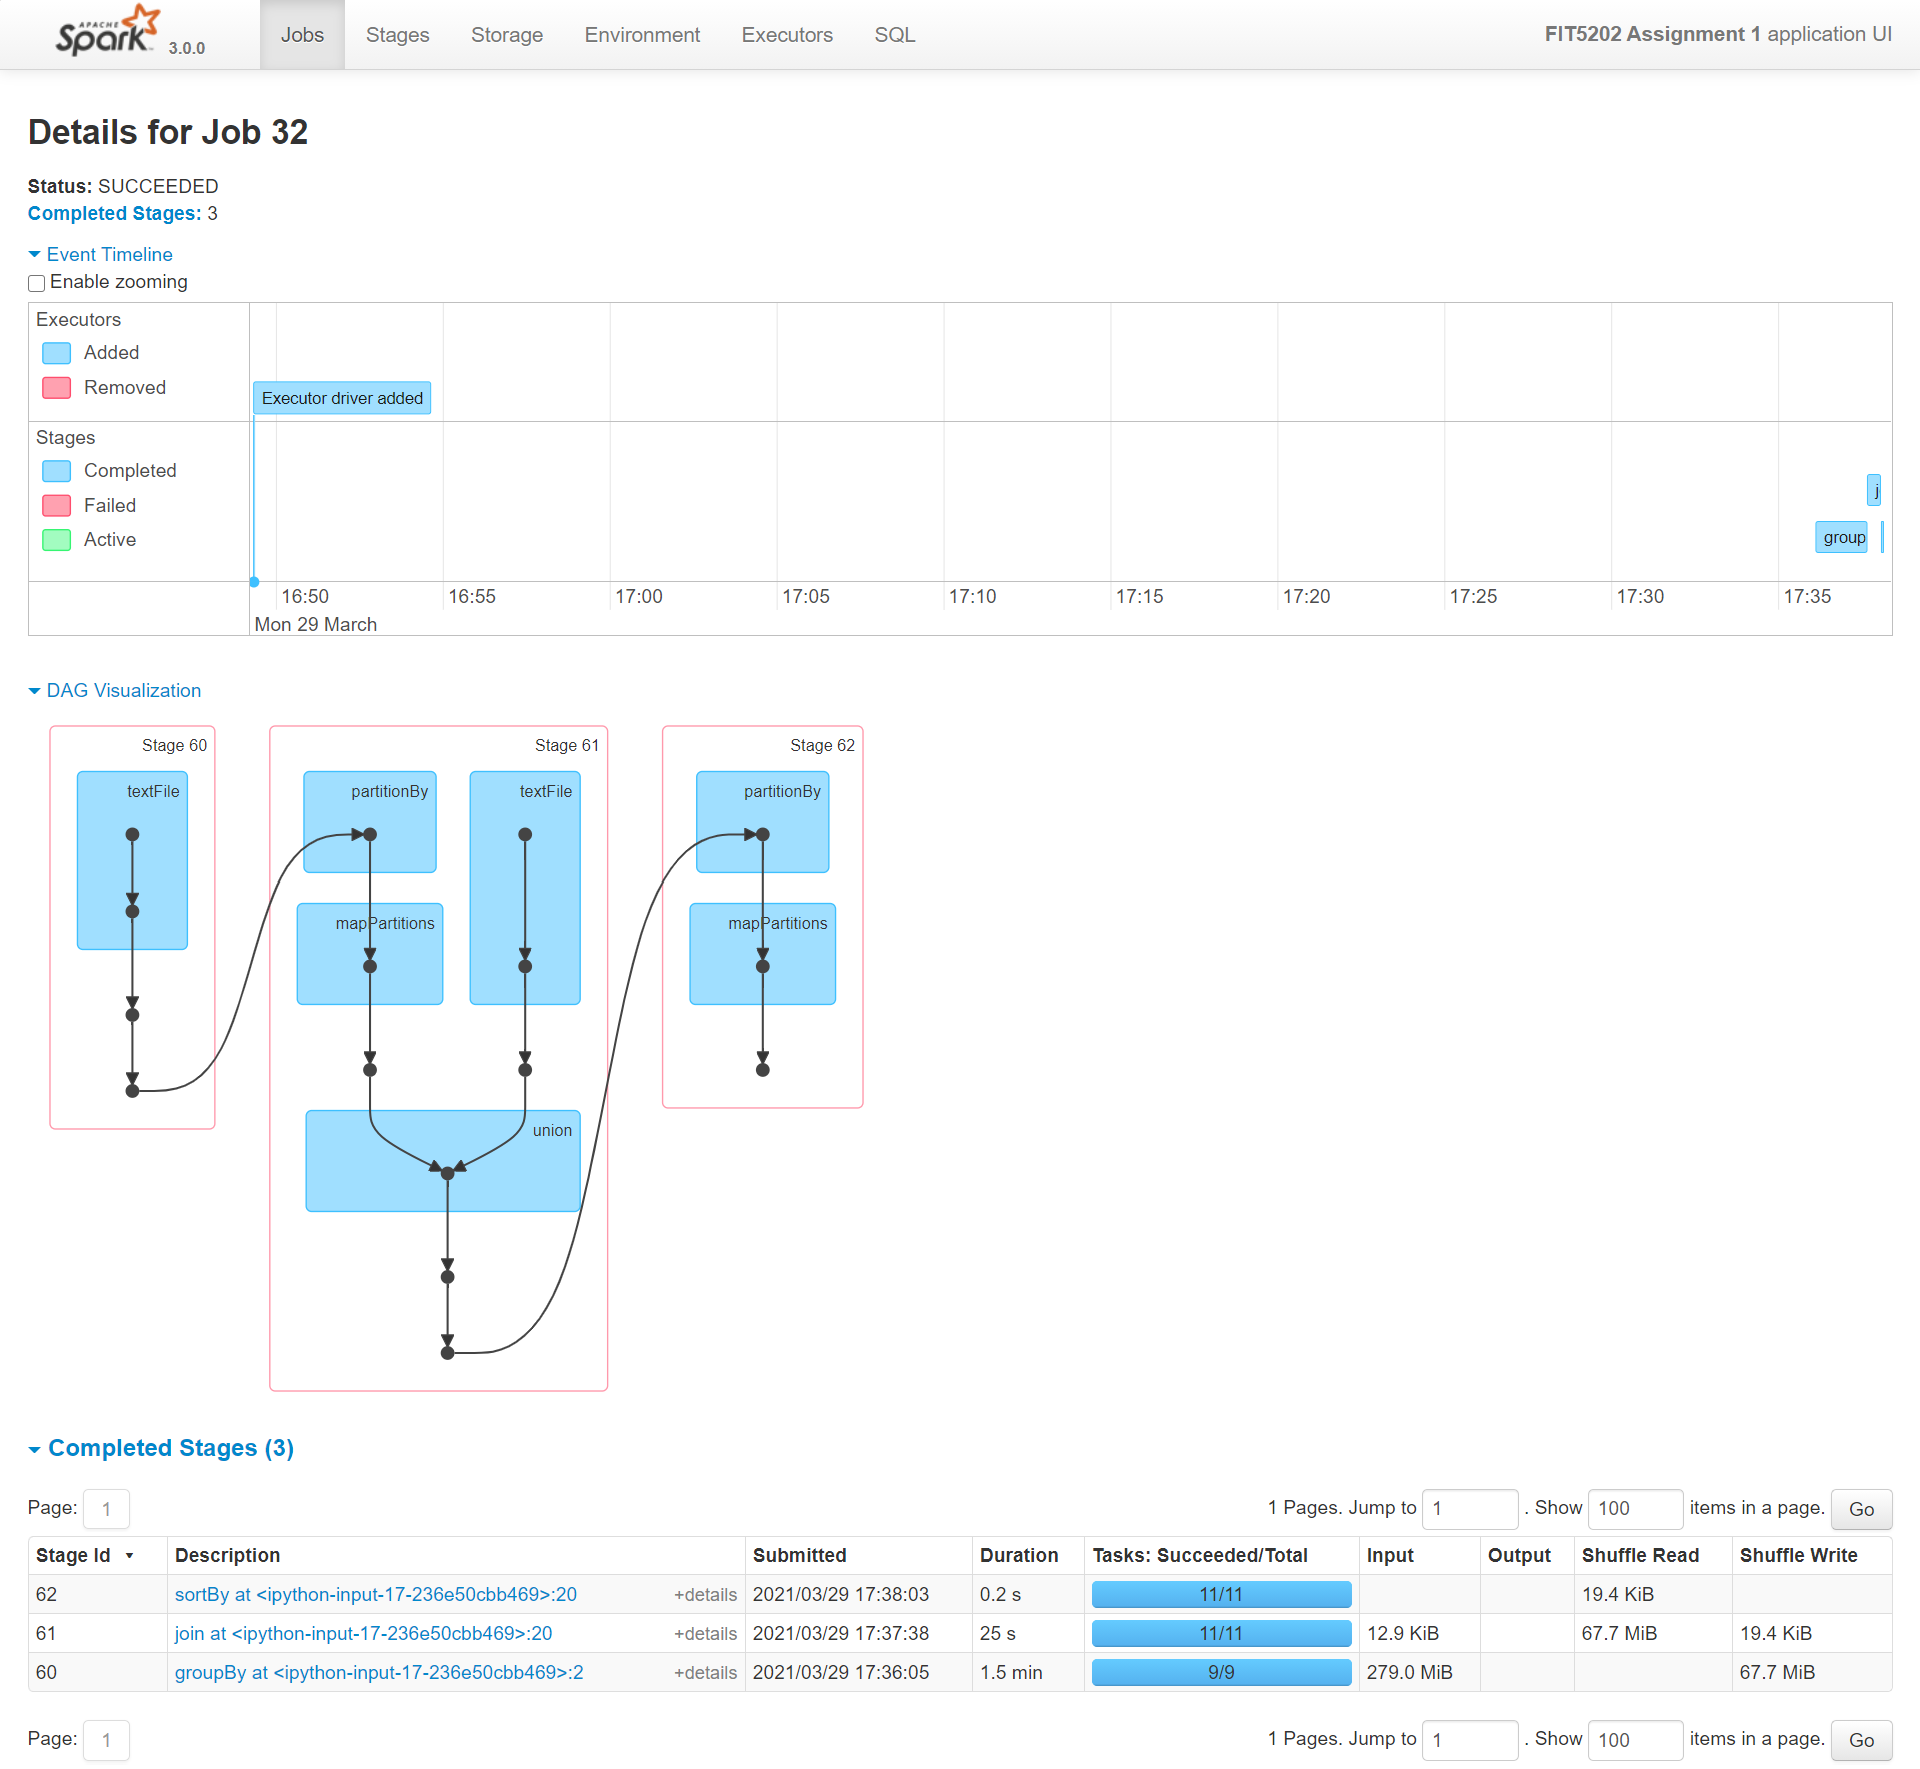
### Figure 1.1

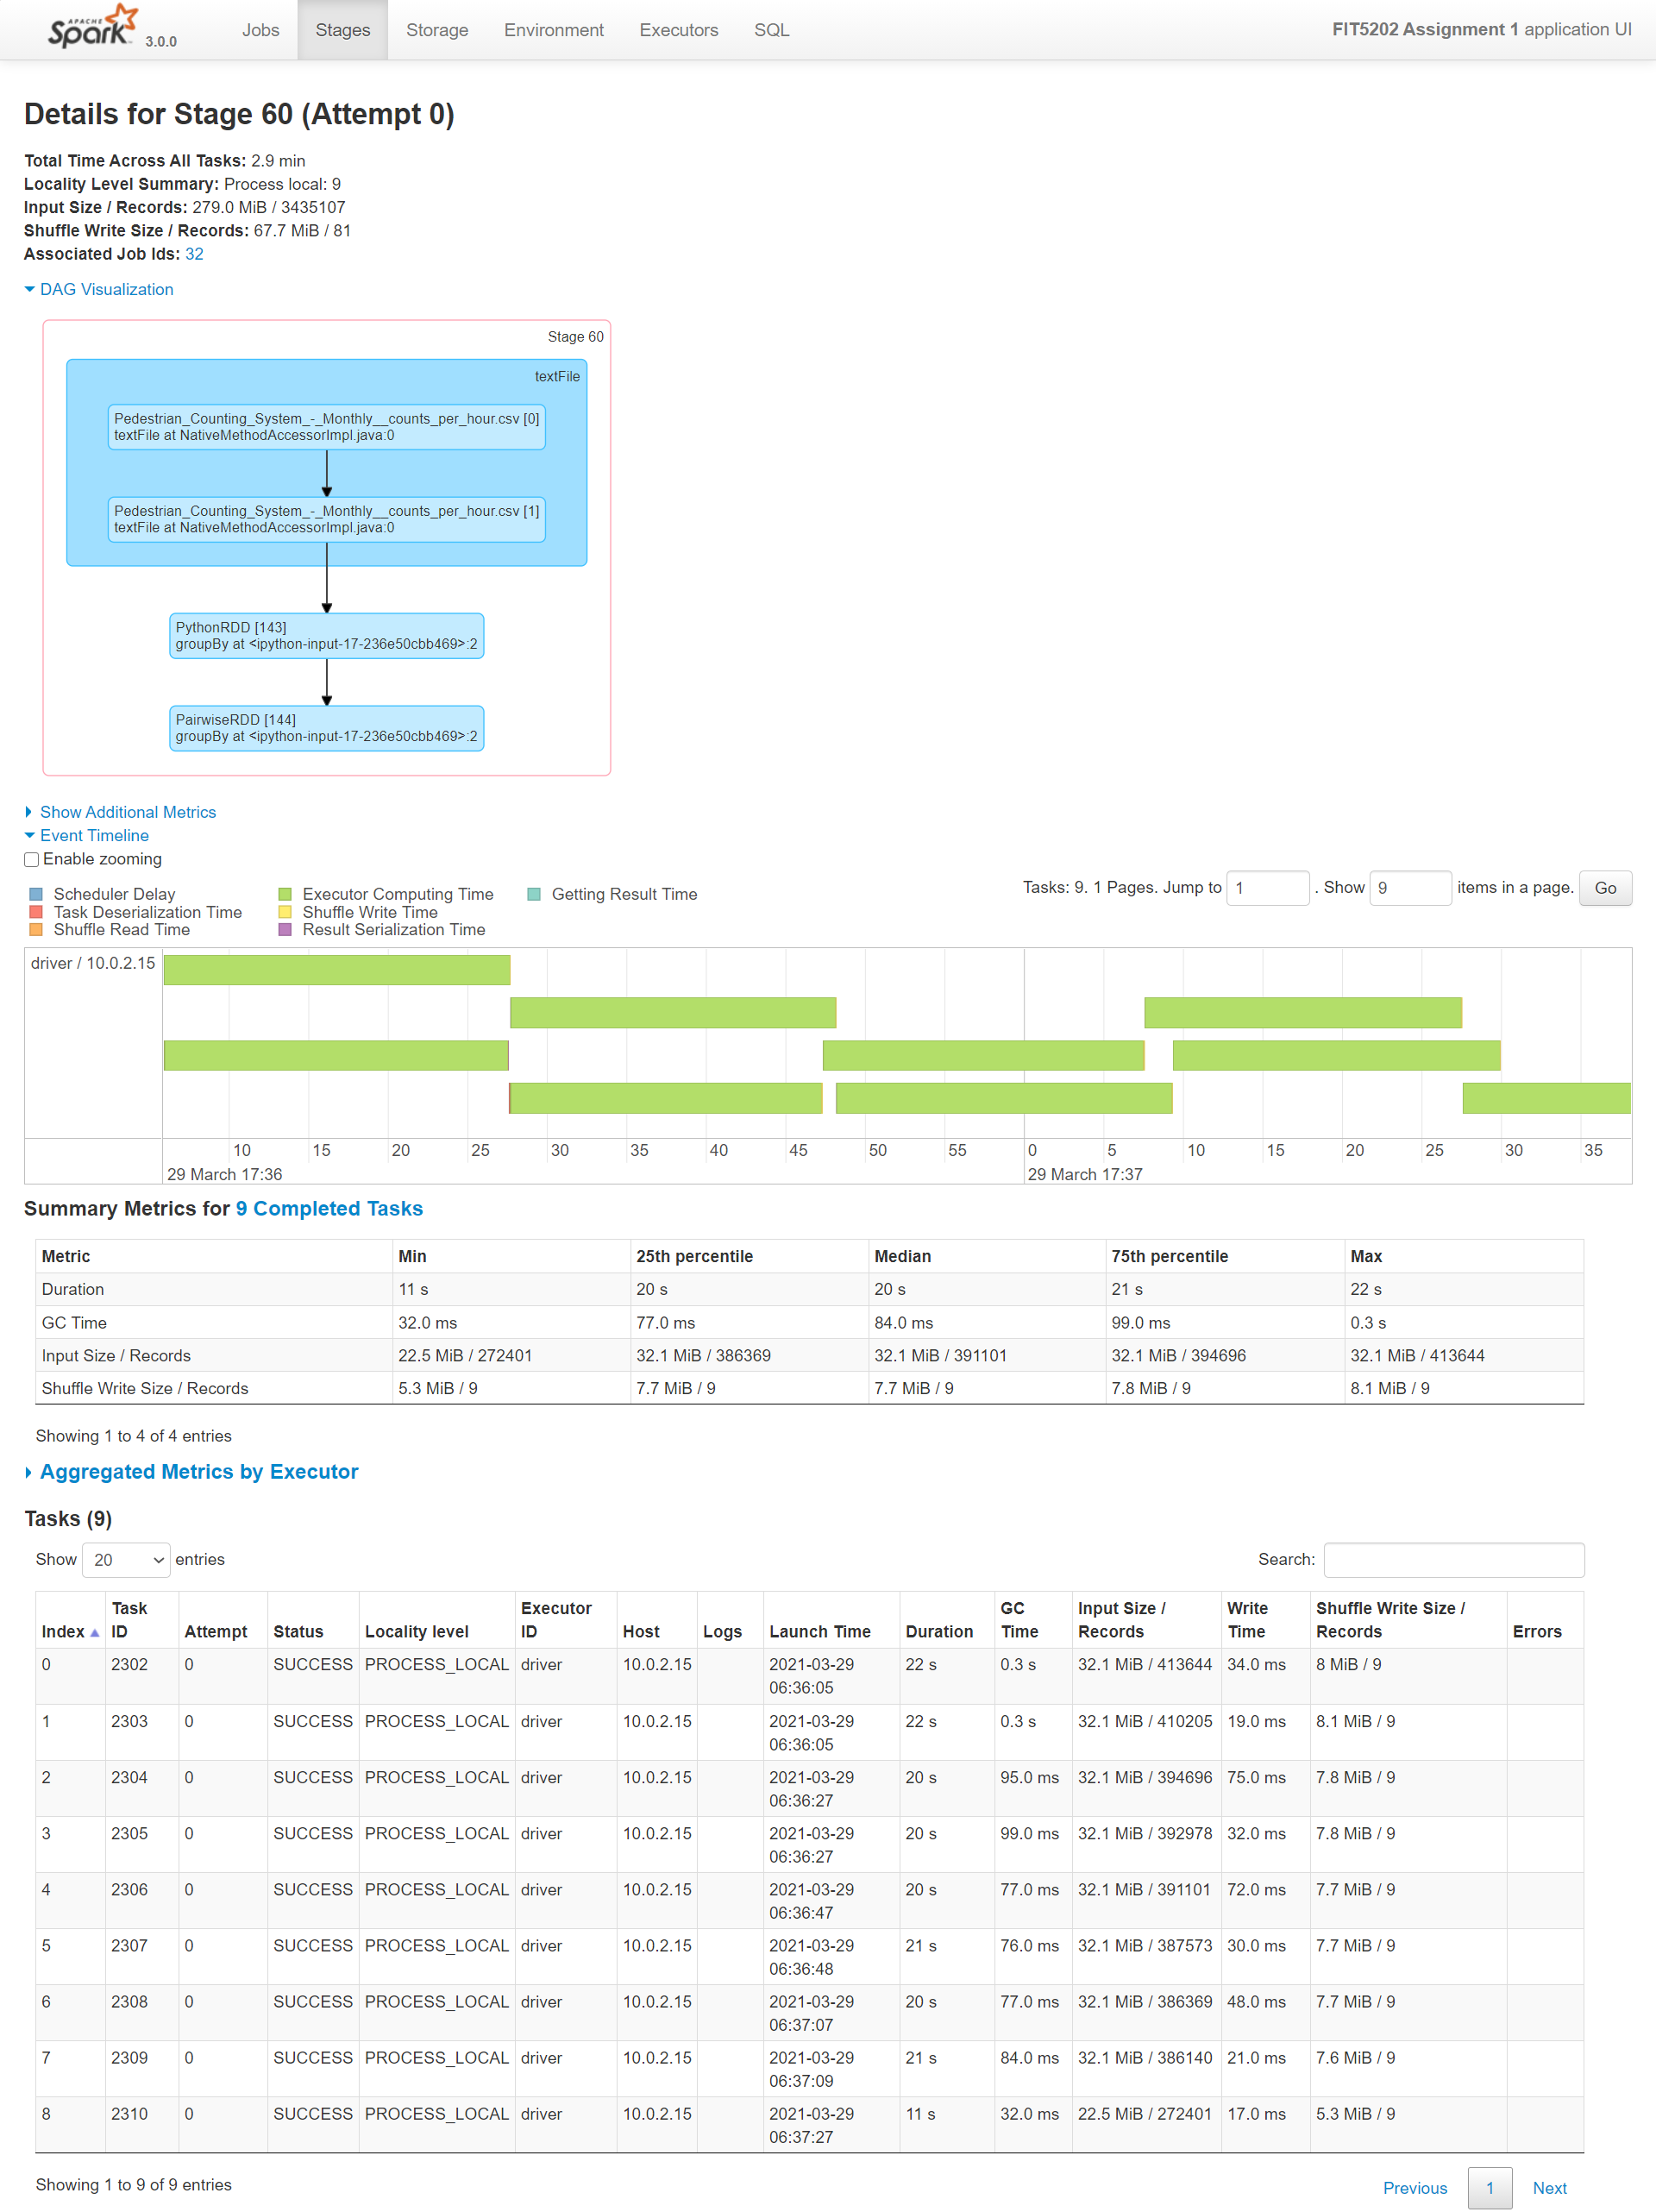
### Figure 1.2

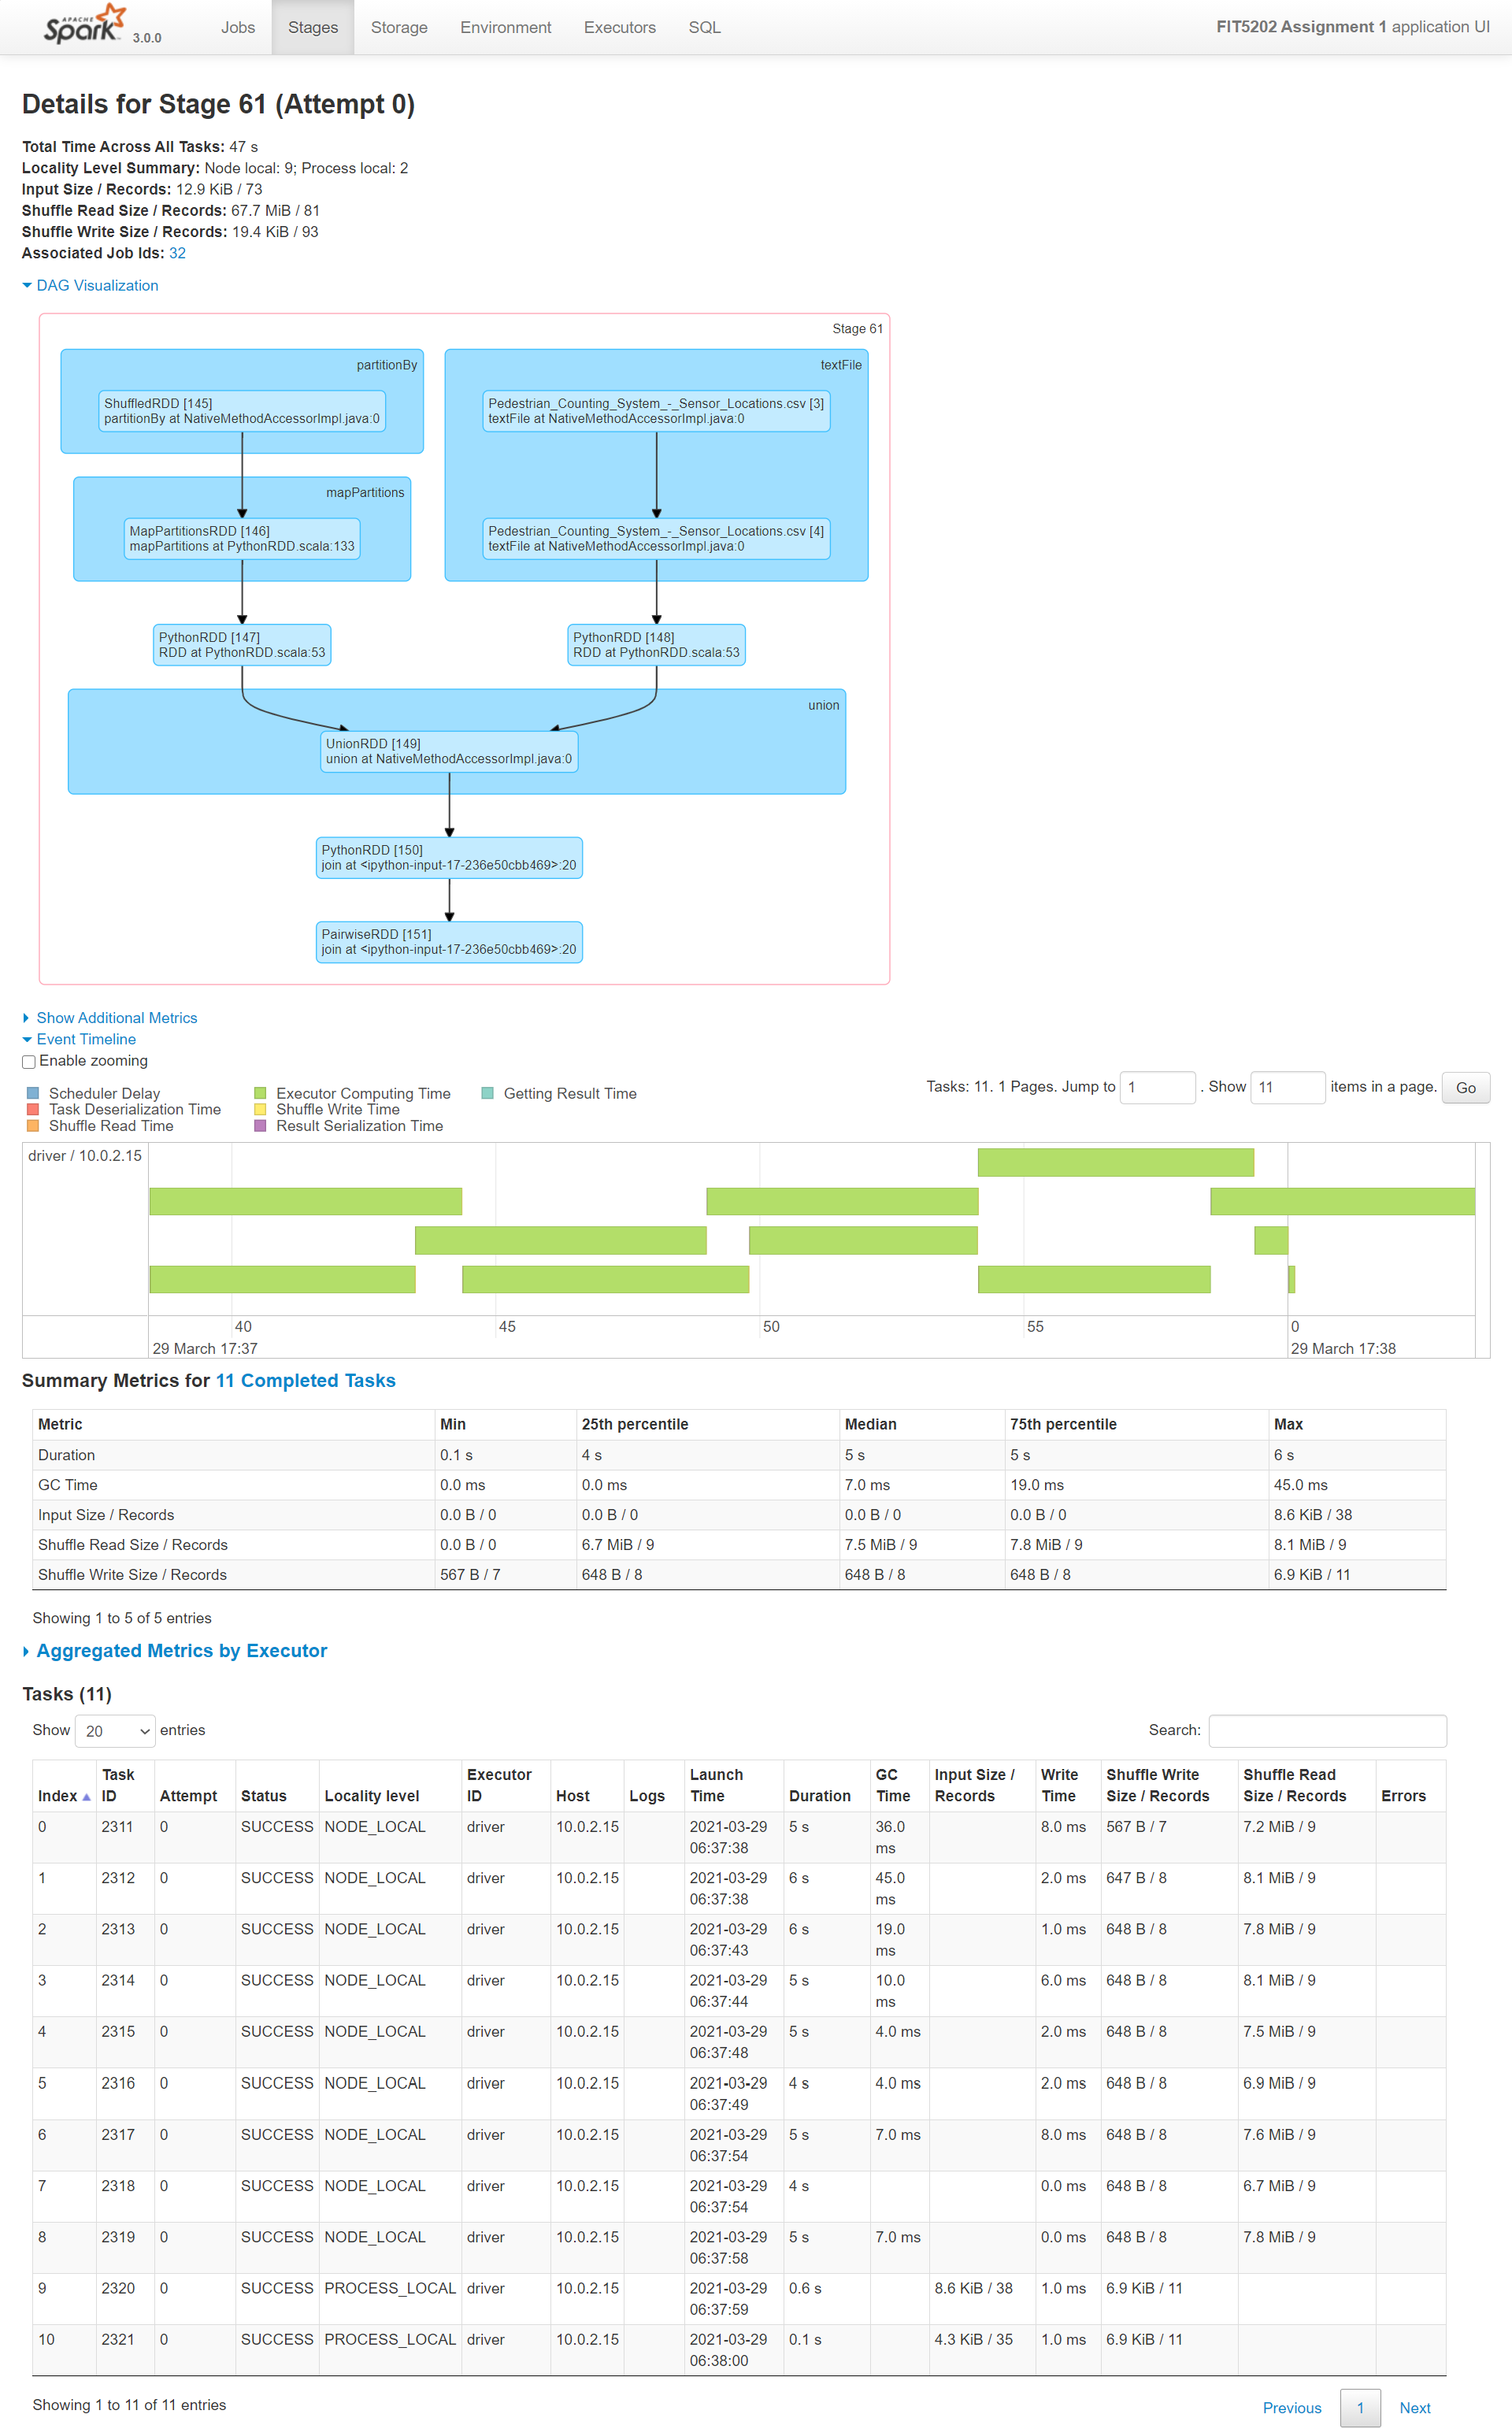
### Figure 1.3

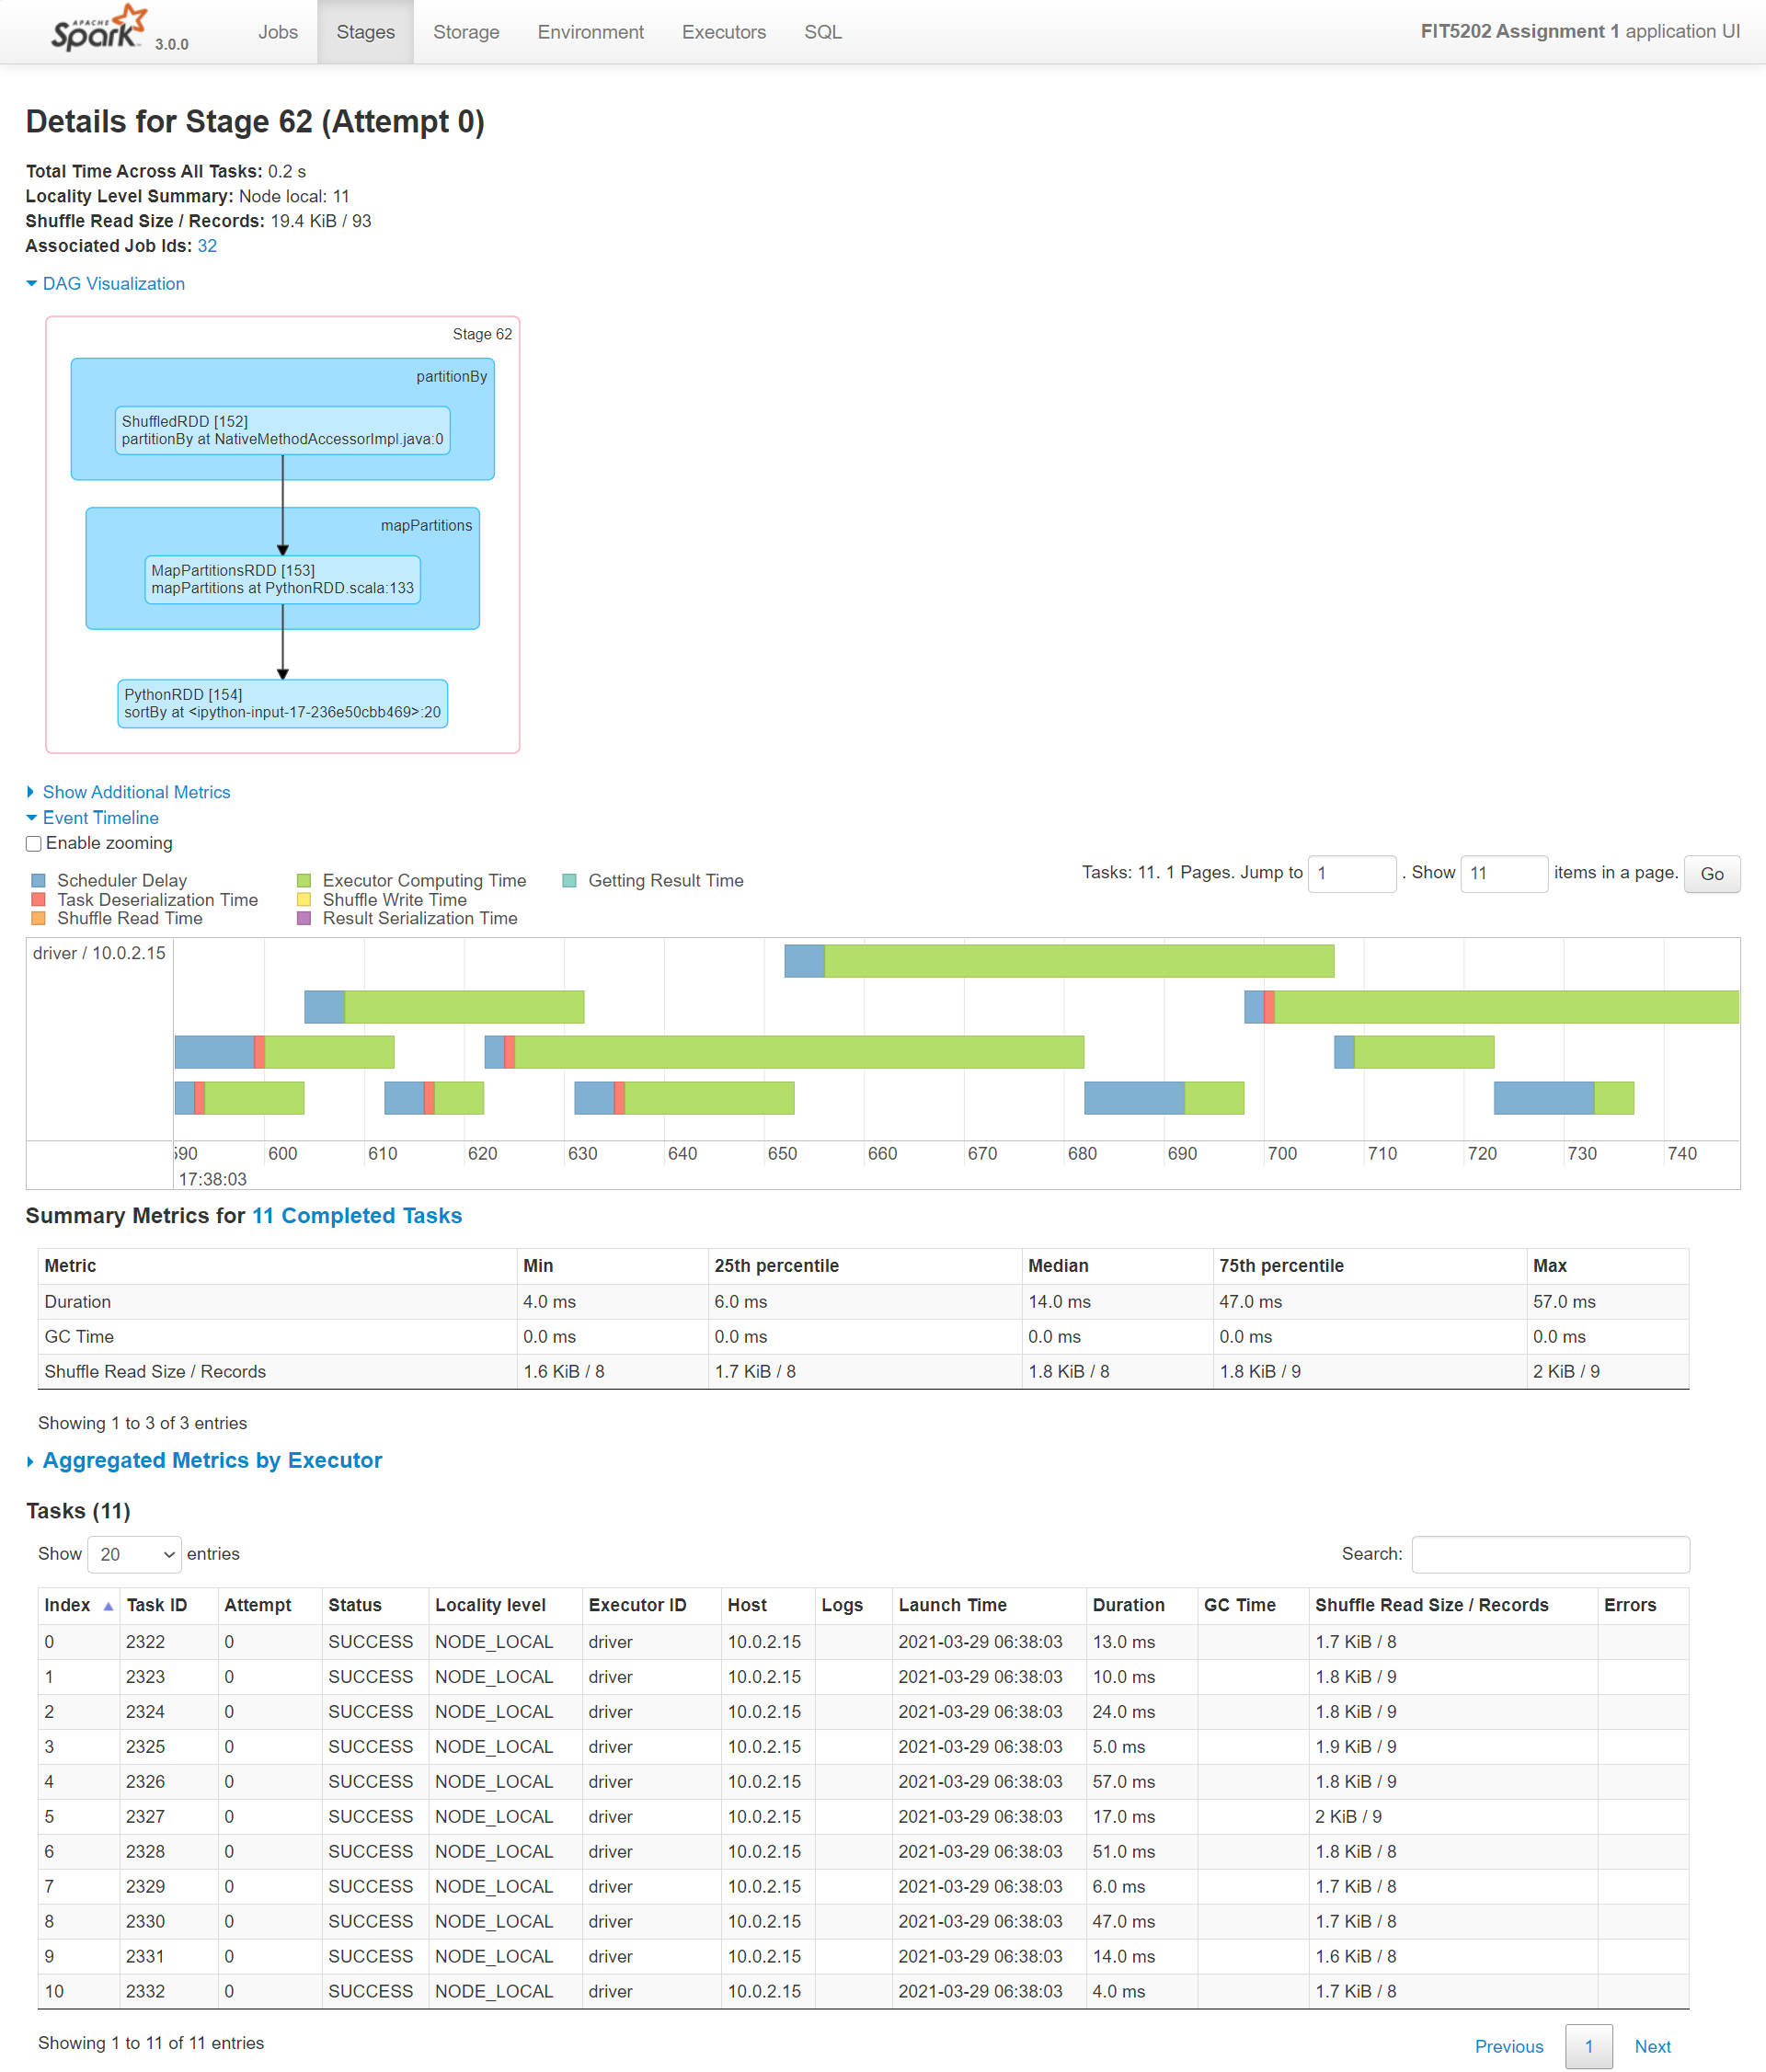
### Figure 1.4

##### Figure 1.1 to Figure 1.4 are screenshots relating to the RDD operation 
##### Figure 1.1 shows the time spent on each job and the overall stage
##### Figure 1.2 to Figure 1.4 shows the task information of each stage in job

## Average sensor count in dataframe Task
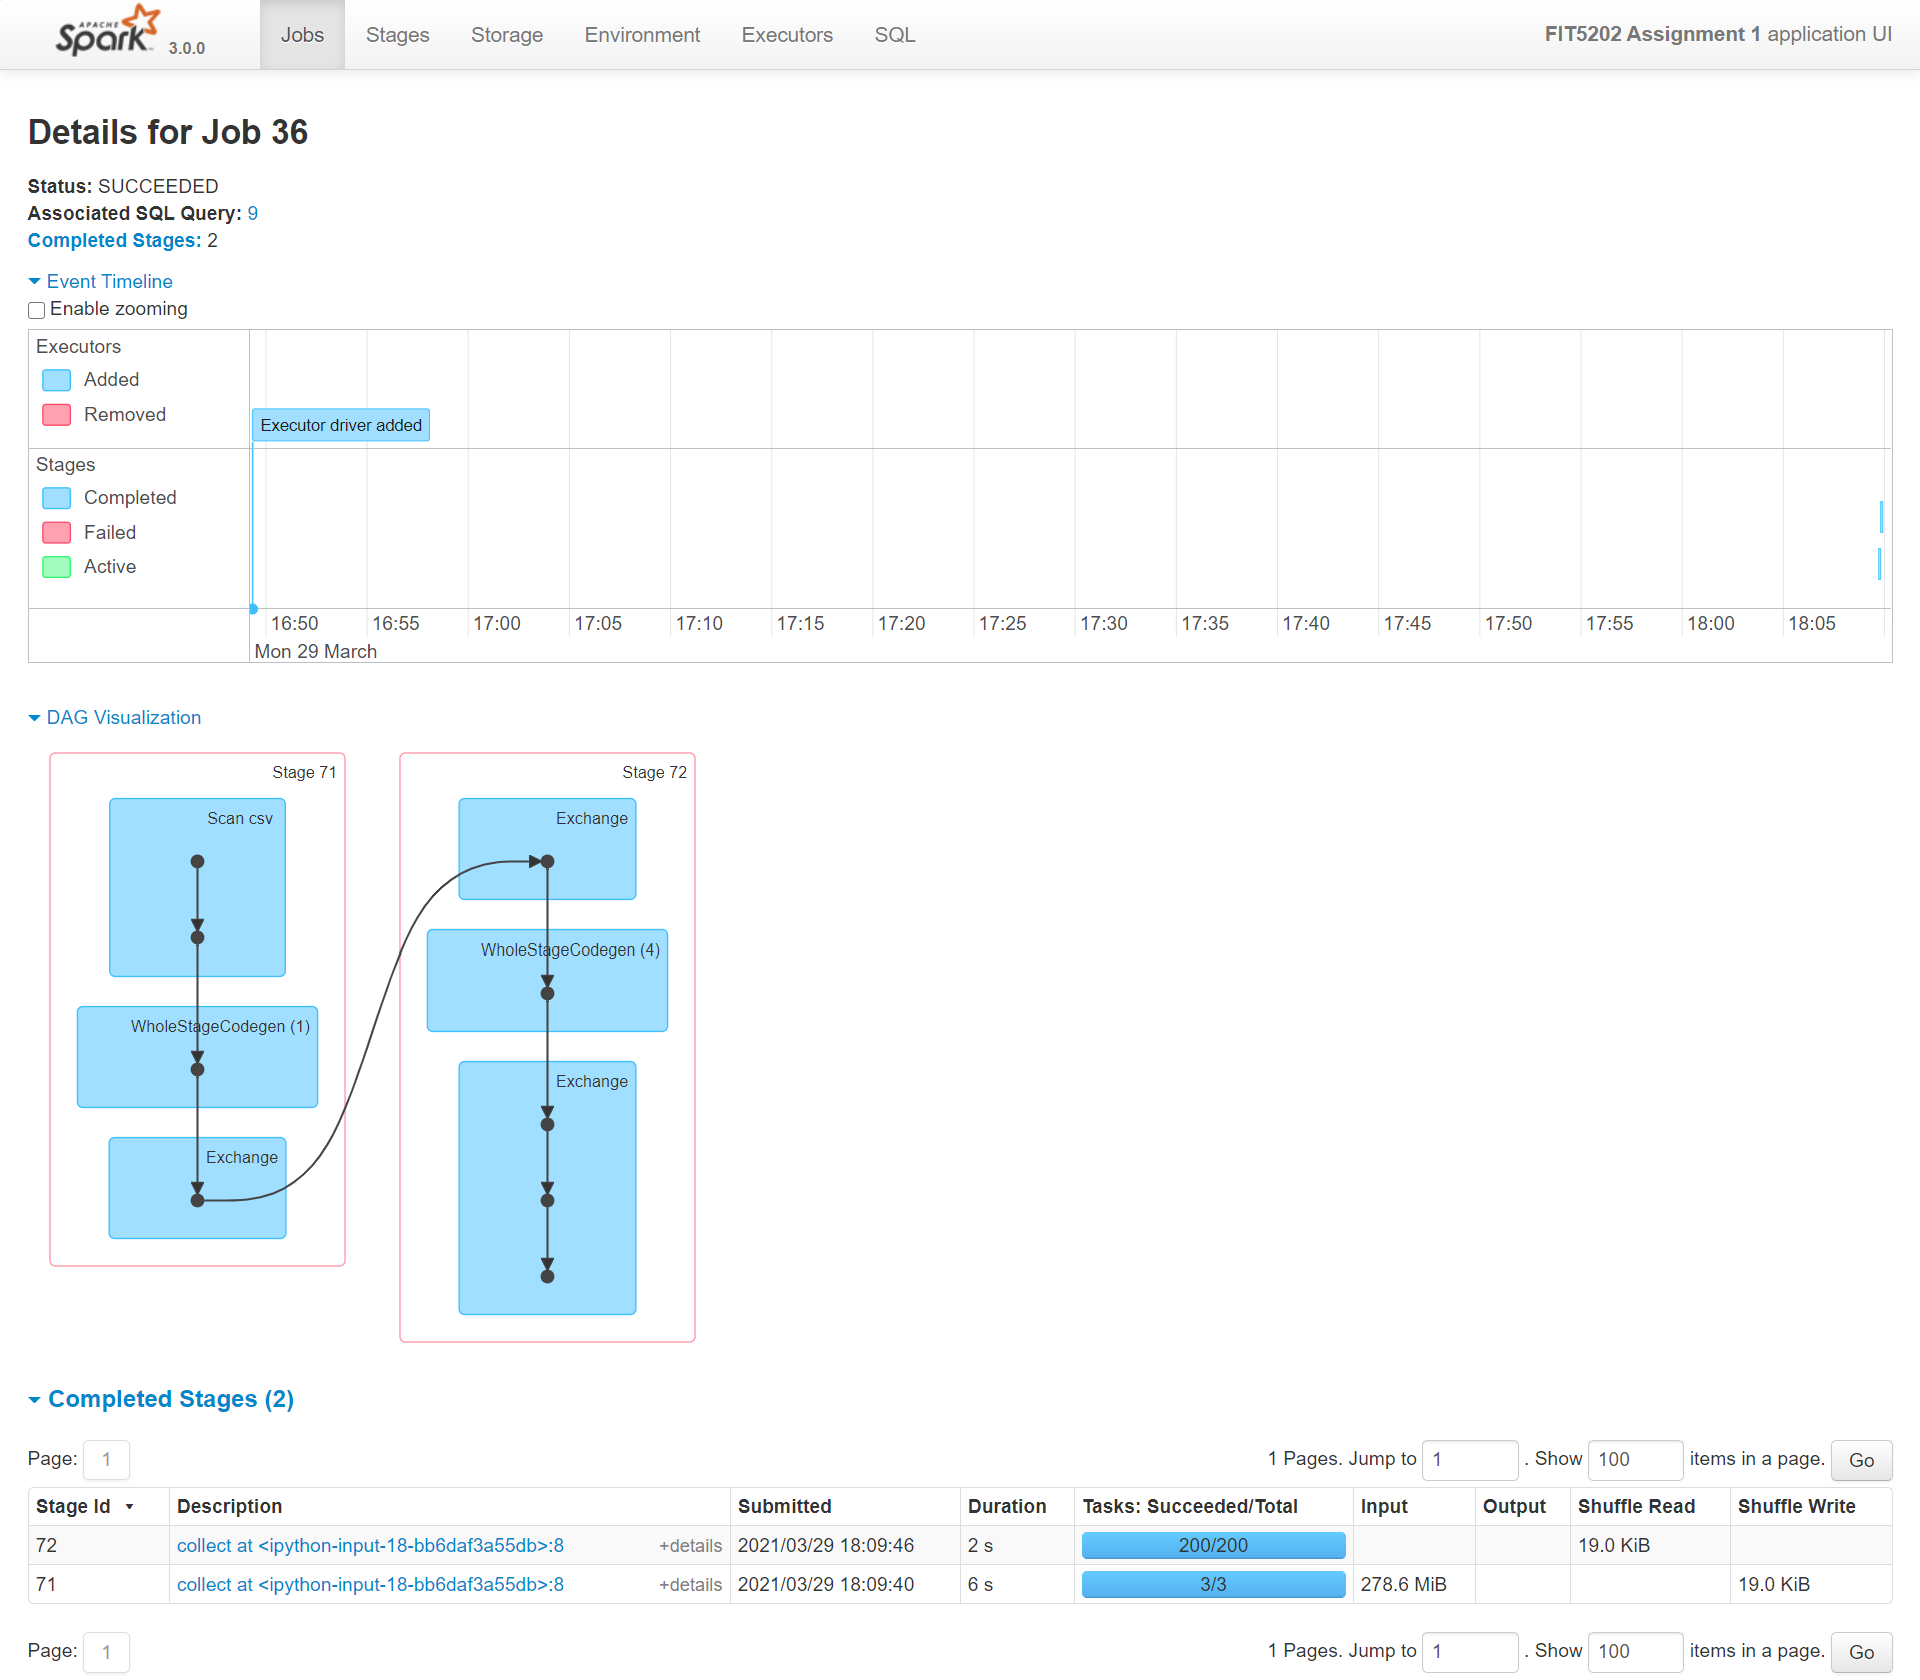
### Figure 2.1
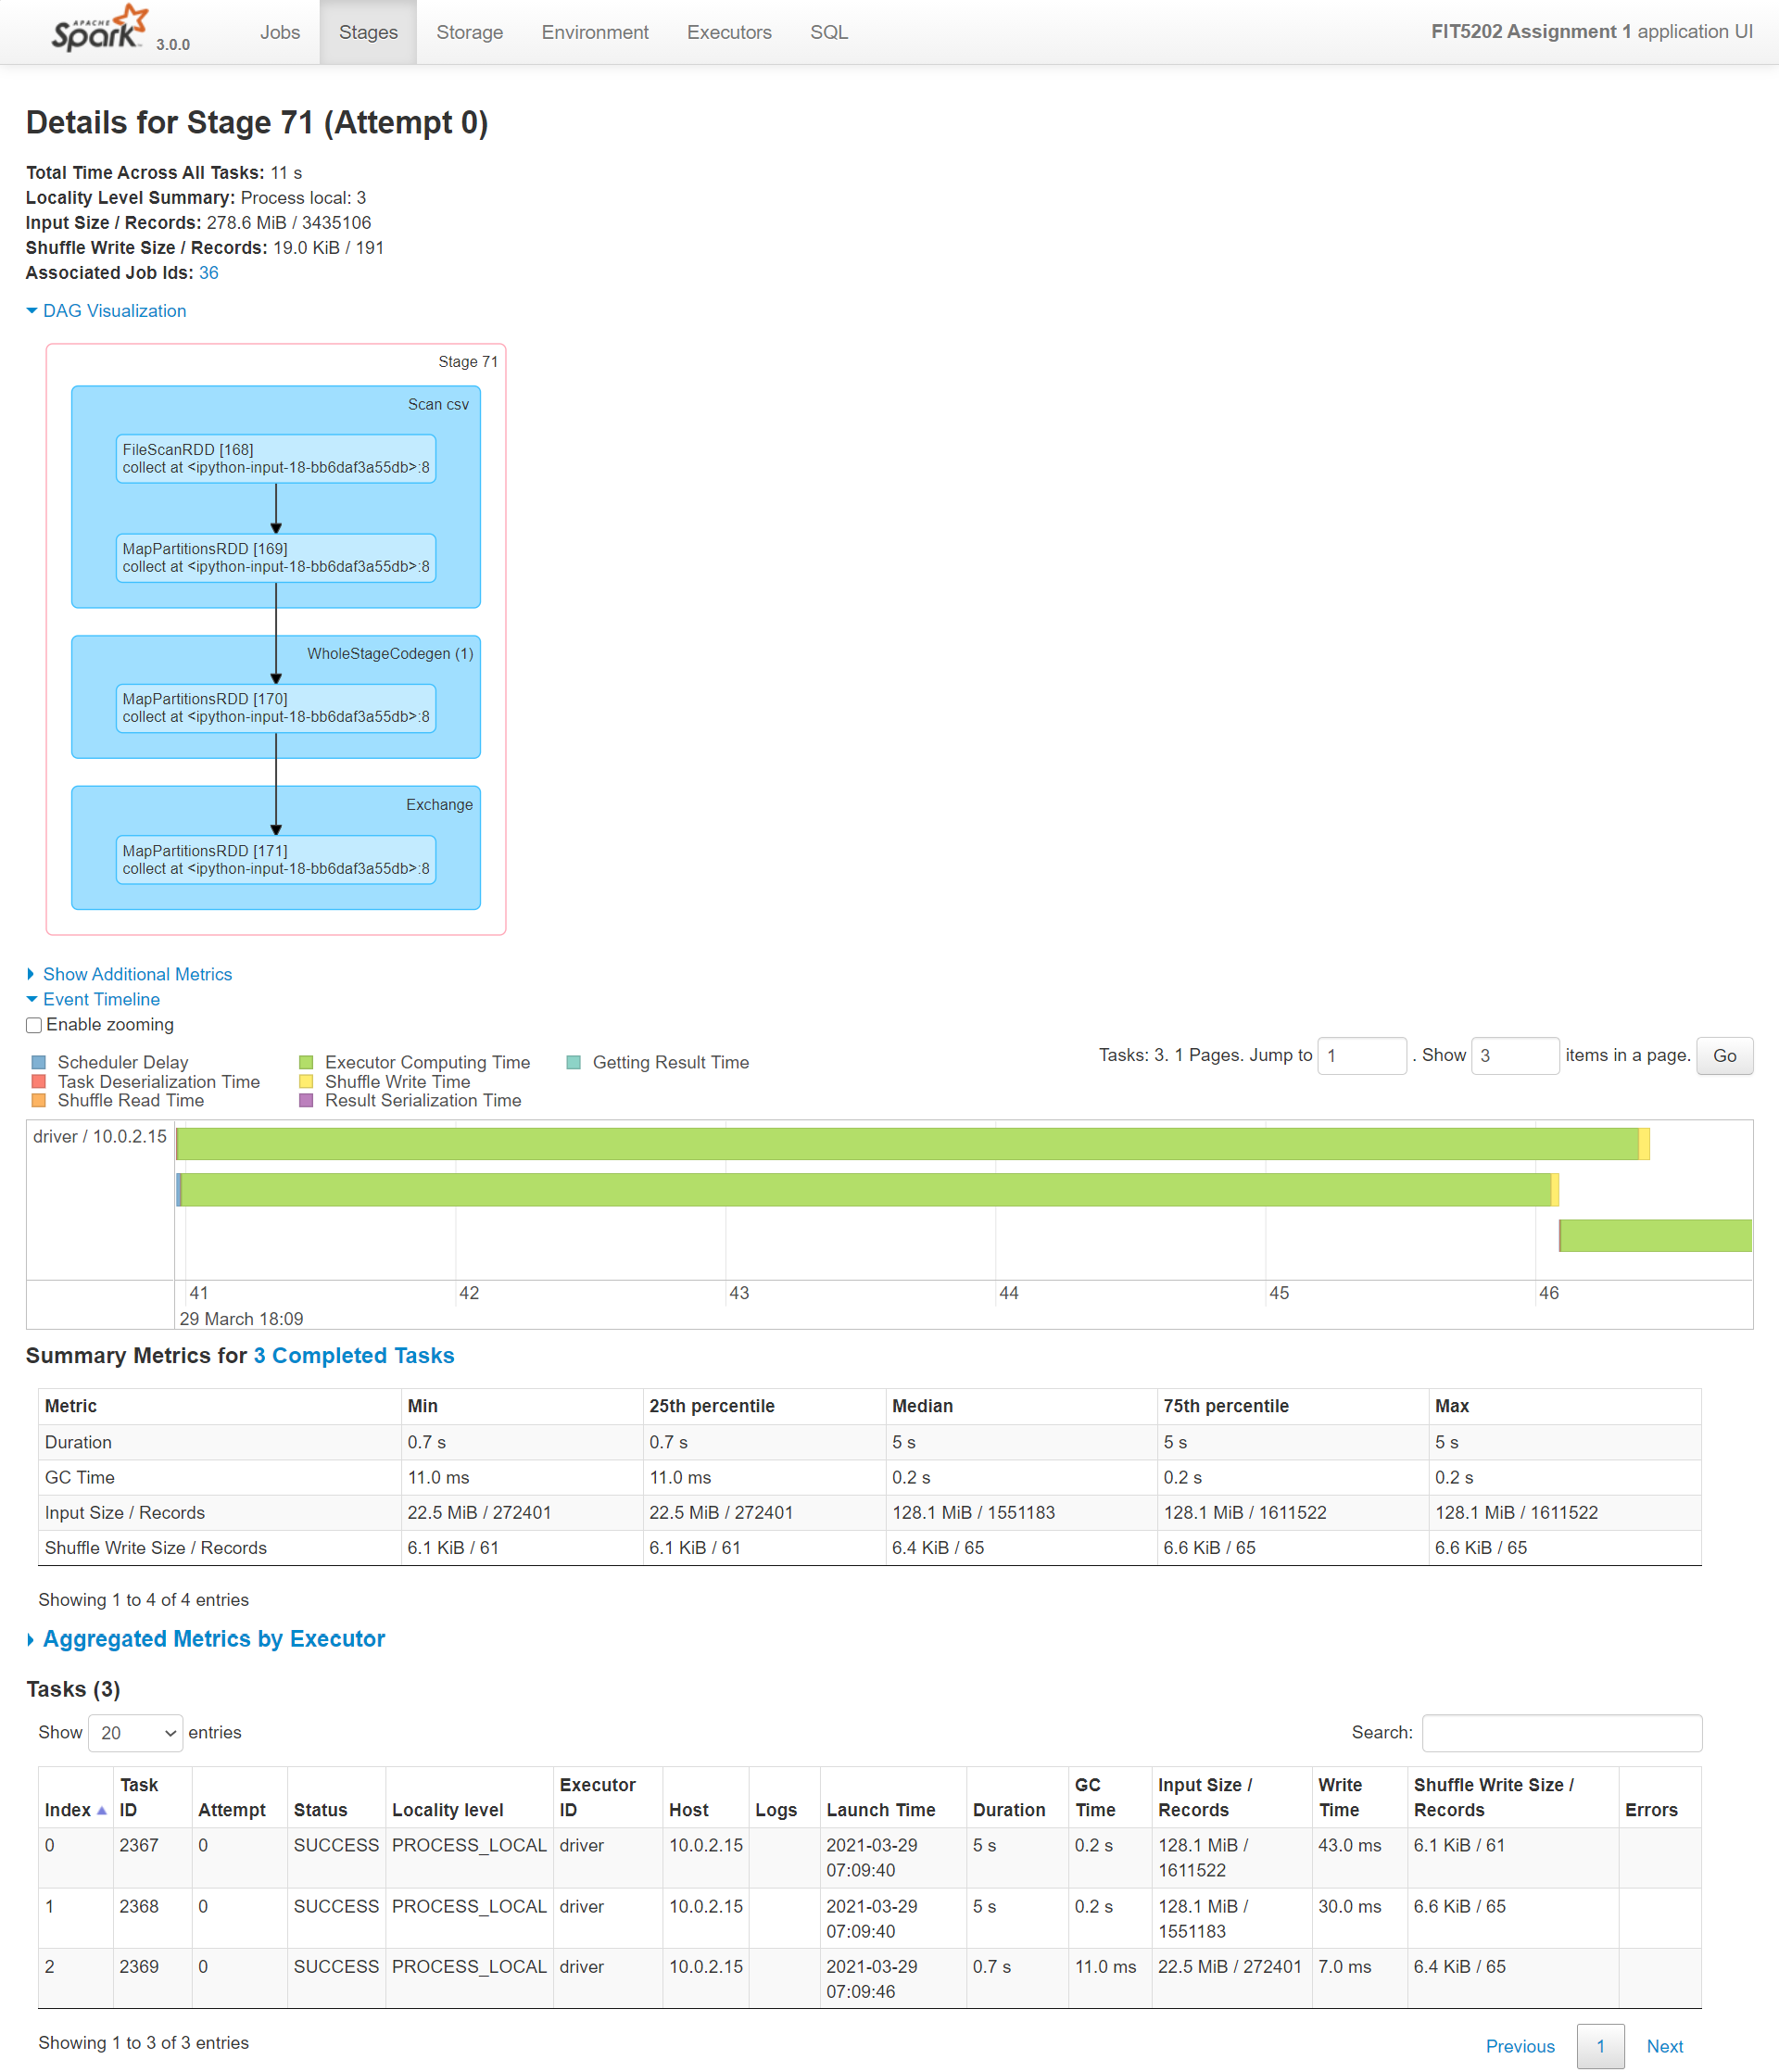
### Figure 2.2
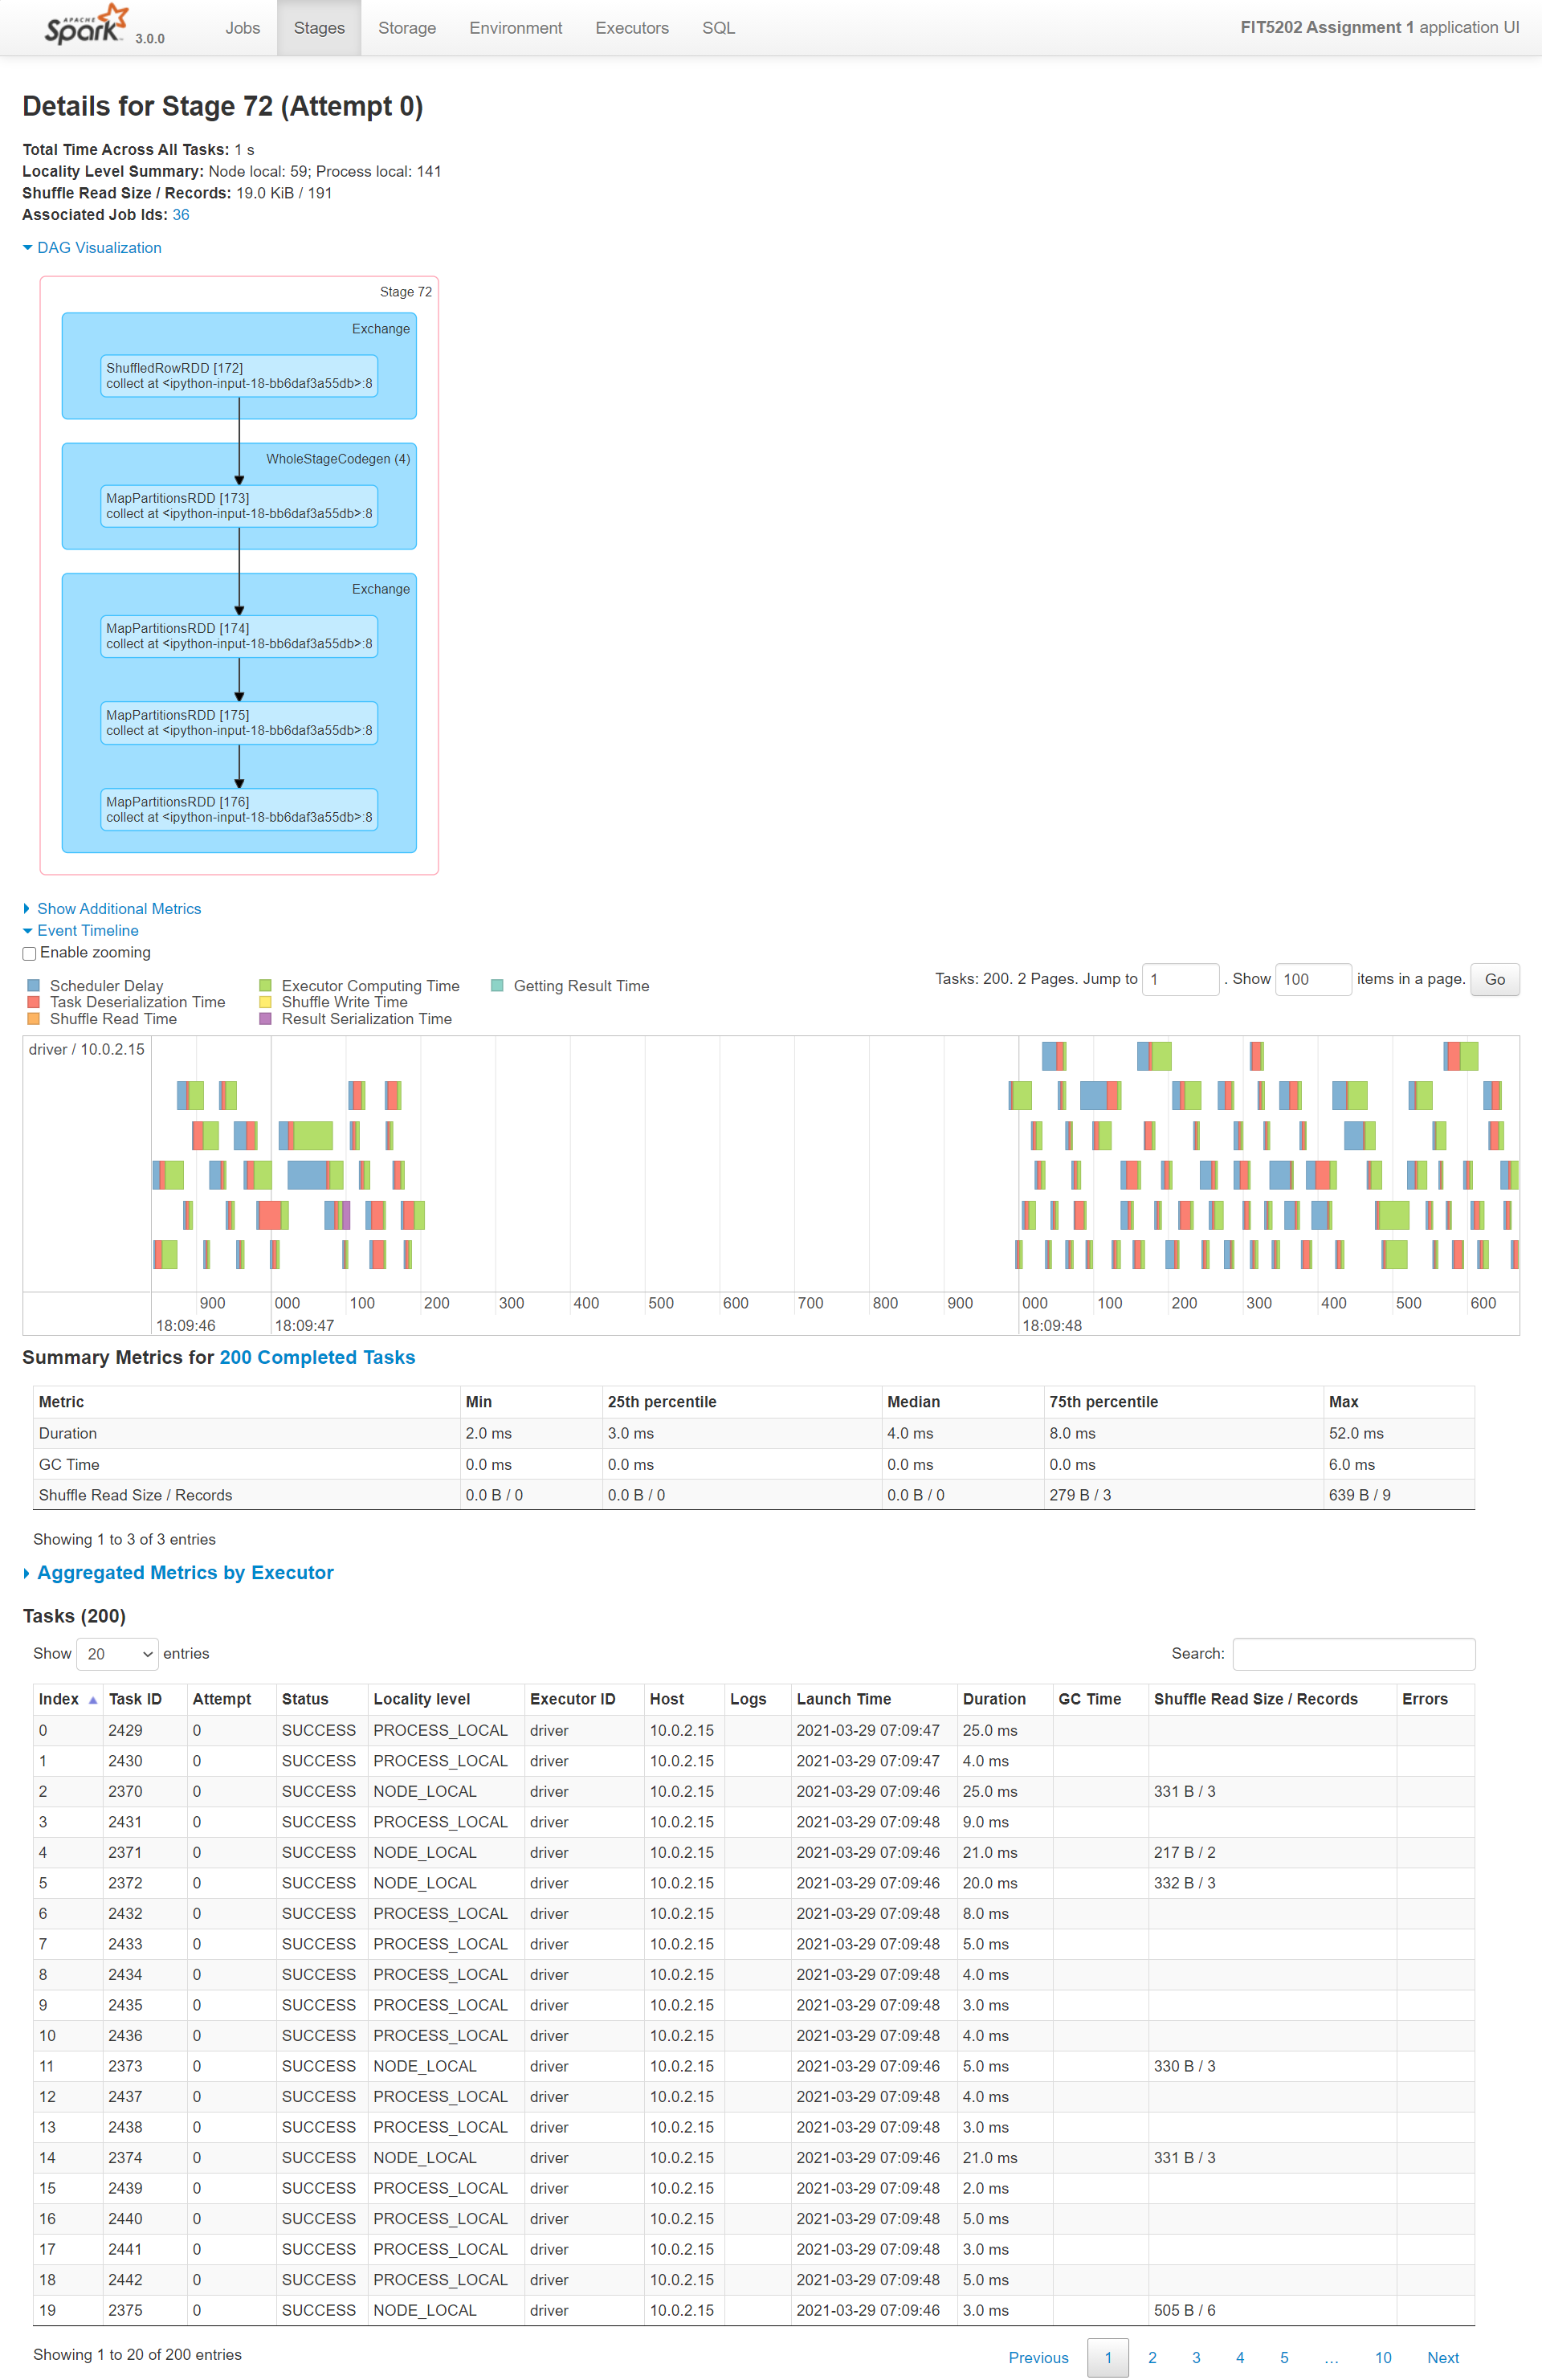
### Figure 2.3

##### Figure 2.1 to Figure 2.3 are screenshots relating to the Dataframe operation in task 2.2.2
##### Figure 2.1 shows the time spent on each job and the overall stage
##### Figure 2.2 to Figure 2.3 shows the task information of each stage in job

## 3.1.2
The dataframe job is much faster than the RDD. One of the reason might be that the dataframe APIs have better performance when compared to RDD APIs for simple things like grouping and aggregation. This can be viewed here https://www.analyticsvidhya.com/blog/2020/11/what-is-the-difference-between-rdds-dataframes-and-datasets/#:~:text=RDD%20is%20slower%20than%20both,a%20bit%20slower%20than%20Dataframes. For proving purposes, there is a comparison made between RDD and dataframes which had the outcome of dataframe performing faster than RDD in most cases, https://www.adsquare.com/comparing-performance-of-spark-dataframes-api-to-spark-rdd/. Overall, I would say RDD is a "low level" API because all operations are manually optimized while writing the operations. In dataframes, Spark will automatically optimize the query when it converts it to RDD's "low level" API.

# 3.2.2 Performance Improvement
## 3.2.1
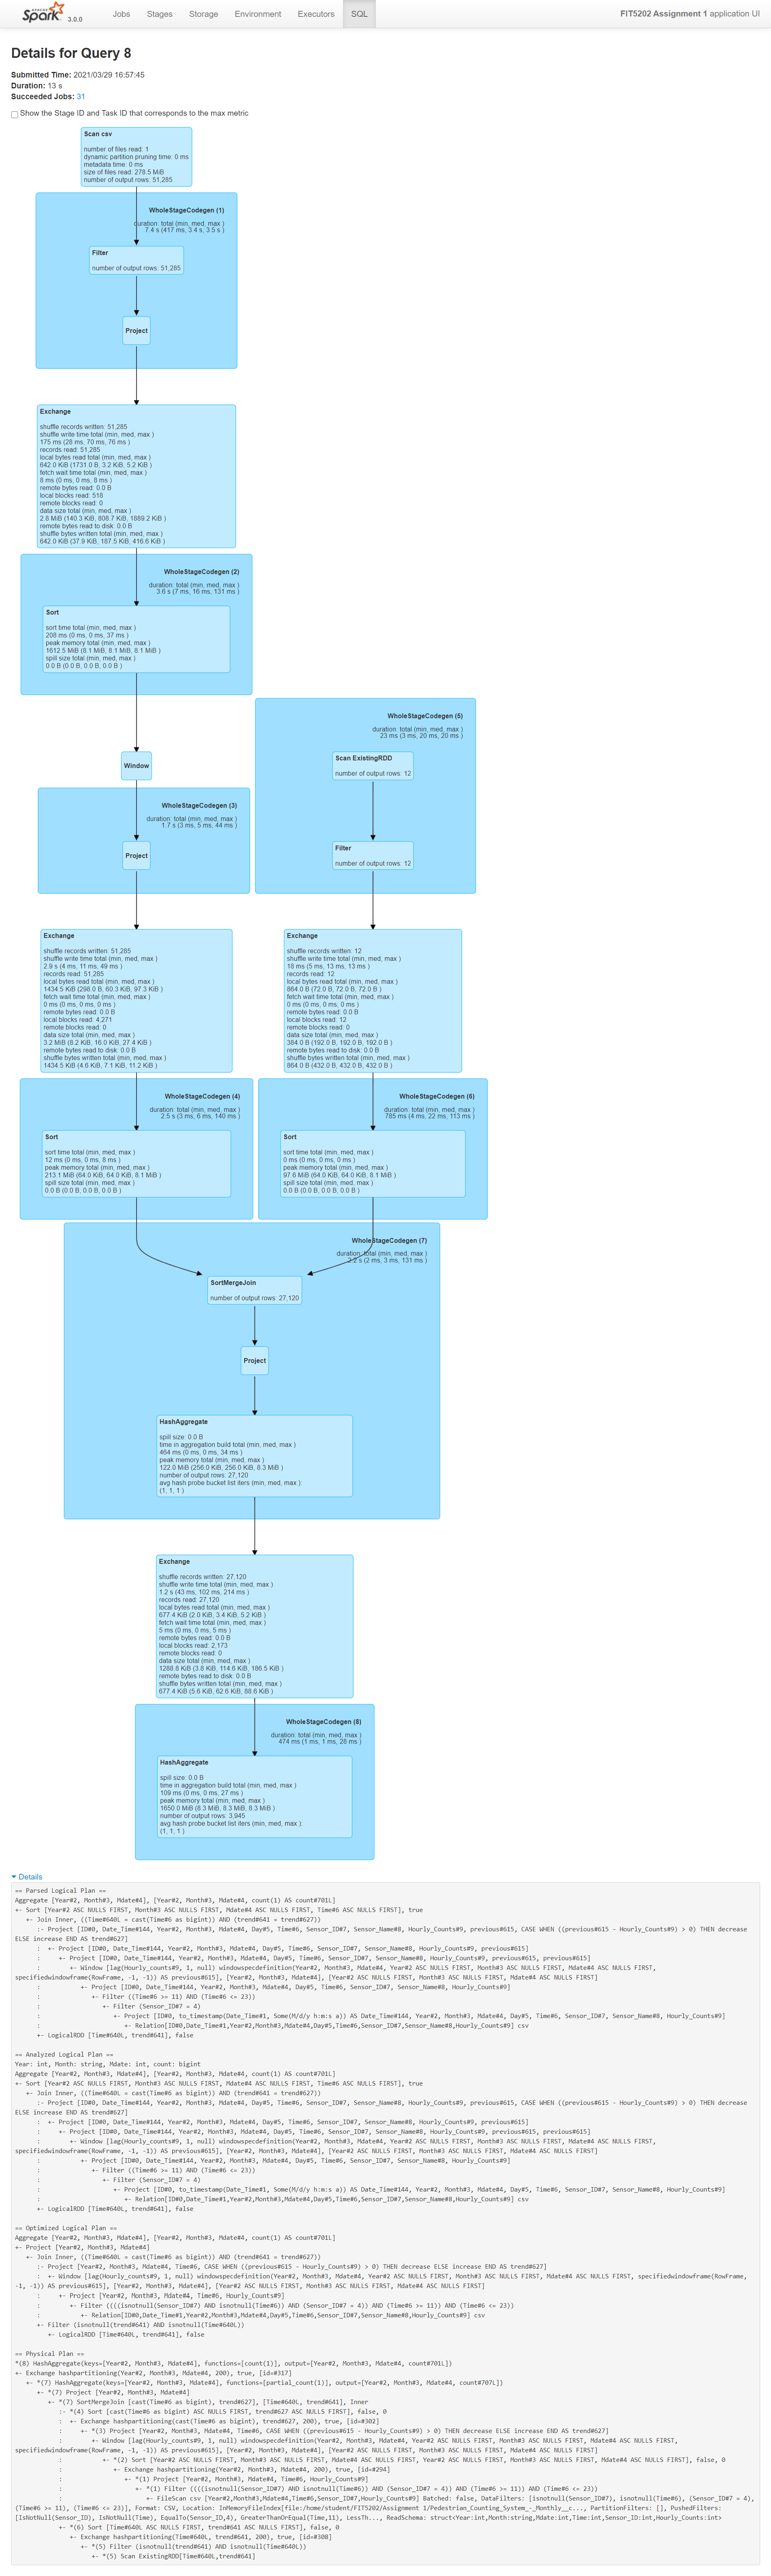
##### Figure 3.1

## 3.3.2

According to apache Spark's documentation, a possible approach to improving this query performance is to convert the sort-merge join to a broadcast join. As seen in Figure 3.1, the blocks WholeStageCodegen (4) and WholeStageCodegen (6) are mergeed using a sort-merge join. In Apache Spark 3.1.1 documentation for tuning performance, when any side of a join is smaller than a broadcast hash join threshold, then a broadcast join is usually selected. In our case, the smaller table would be the "trend_df" created as it only has 12 entries, this should also mean that it is lower than the broadcast hash join threshold of Apache Spark. For example, in our case, instead of sorting the very large table and trying to match the rows of the larger table with the smaller "trend_df" table, the smaller table can be braodcasted to multiple processors and the join operation can be carried out in each of the processor. This way we can also save time in sorting the data.

Another possible way to improve this query performance is to cache data in memory, according the Apache Spark documentation, Spark SQL can cache tables using an in-memory columnar format by calling spark.catalog.cacheTable("tableName") or dataFrame.cache(). With this, Spark SQL will scan only required columns and will automatically tune the compression to minimioze memory usage and GC pressure. For example, in Figure 3.1, some of the Exchange blocks have very high read/write time. By caching data in memory, we might be able to cut down on the read/write time and improve the performance of the query.

Source: https://spark.apache.org/docs/latest/sql-performance-tuning.html

# Part B
## 2 Yearly Trend

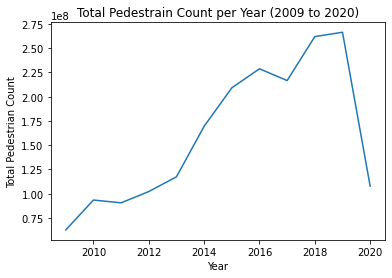

In [19]:
x = []
y = []
avg_y = []

for row in yearly_total_pedes_df:
    x.append(row["Year"])
    y.append(row["sum(Hourly_Counts)"])

for row in yearly_avg_pedes_df:
    avg_y.append(row["avg(sum(Hourly_Counts))"])
       
plot = plt.plot(x, y)
plot = plt.xlabel("Year")
plot = plt.ylabel("Total Pedestrian Count");
plot = plt.title("Total Pedestrain Count per Year (2009 to 2020)")

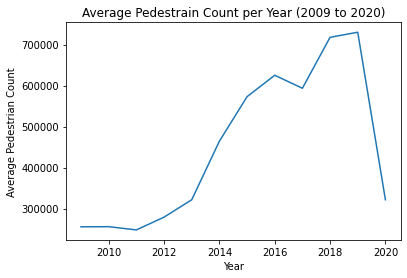

In [20]:
avg_plot = plt.plot(x, avg_y)
avg_plot = plt.xlabel("Year")
avg_plot = plt.ylabel("Average Pedestrian Count");
avg_plot = plt.title("Average Pedestrain Count per Year (2009 to 2020)")